# BLOCK 0 — SETUP

Run once per session. Contains: imports, global parameters, font registration, and `super_mongo()` definition.

> **Do not re-run** unless the Python environment has been restarted.

In [1]:
# =============================================================================
# SETUP CELL: IMPORTS AND GLOBAL PARAMETERS
# =============================================================================

# --- Standard Library Imports ---
import warnings
import logging
import os
import time

#!pip install umap-learn
# --- Data Analysis and Numerical Imports ---
import numpy as np
import pandas as pd
from scipy import stats

# --- Imports de Machine Learning (Scikit-learn) ---
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, HDBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score
)
from sklearn.preprocessing import MinMaxScaler # For visualisation

# --- Astronomical Library Imports ---
from astropy.timeseries import LombScargle
from astropy import units as u

# --- Dimensionality Reduction and Visualisation Imports ---
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# --- Global Settings ---
# Suppress warnings for a clean notebook
warnings.filterwarnings('ignore')

# Logging configuration
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger.info(f"Global random seed set to {RANDOM_STATE}")

# Visualisation Settings (Matplotlib and Seaborn)
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'pdf' # Vector format for publications

# Directory for saving figures
FIG_DIR = "figures"
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
    logger.info(f"Figures directory created at: {FIG_DIR}")

# --- Helper Functions ---
def save_figure(fig, name, tight_layout=True):
    """
    Saves a matplotlib figure in multiple formats (PDF, PNG) 
    in the defined figures directory.
    """
    if tight_layout:
        plt.tight_layout()
        
    path_pdf = os.path.join(FIG_DIR, f"{name}.pdf")
    path_png = os.path.join(FIG_DIR, f"{name}.png")
    
    fig.savefig(path_pdf, bbox_inches='tight')
    fig.savefig(path_png, bbox_inches='tight')
    logger.info(f"Figura salva em {path_pdf} e {path_png}")



logger.info("Ambiente configurado com sucesso.")

2026-02-23 00:15:55,245 - INFO - Global random seed set to 42
2026-02-23 00:15:55,247 - INFO - Ambiente configurado com sucesso.


In [2]:
# =============================================================================
# LOCAL REGISTRATION OF COURIER PRIME FONT (EMBEDDED IN PROJECT)
# =============================================================================
import matplotlib.font_manager as fm
from pathlib import Path

FONT_DIR = Path("fonts")

for font_path in FONT_DIR.glob("*.ttf"):
    fm.fontManager.addfont(str(font_path))

# Explicit verification
available_fonts = {f.name for f in fm.fontManager.ttflist}
assert "Courier Prime" in available_fonts, "Courier Prime NOT found!"

print("Courier Prime registered successfully.")

Courier Prime registered successfully.


In [3]:
import matplotlib.font_manager as fm

[f.name for f in fm.fontManager.ttflist if "Courier Prime" in f.name]


# =============================================================================
# GLOBAL FONT CONFIGURATION – PAPER (Courier Prime)
# =============================================================================
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({

    # Main font
    "font.family": "monospace",
    "font.monospace": ["Courier Prime"],

    # Base sizes (fine-tune later if needed)
    "font.size": 13,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "legend.fontsize": 12,

    # Mathtext (important for labels with symbols)
    "mathtext.fontset": "custom",
    "mathtext.rm": "Courier Prime",
    "mathtext.it": "Courier Prime:italic",
    "mathtext.bf": "Courier Prime:bold",

    # Axis appearance (paper-grade)
    "axes.linewidth": 1.0,

    # Export settings
    "pdf.fonttype": 42,   # TrueType → garante embedding da fonte
    "ps.fonttype": 42,

    "savefig.format": "pdf",
    "savefig.dpi": 300,
})

In [4]:
import sys
!{sys.executable} -m pip install umap-learn

In [5]:
# =============================================================================
# VERSION CHECK CELL
# =============================================================================
import sys
import sklearn
import astropy
import statsmodels
import plotly

logger.info(f"Python version: {sys.version.split()}")
logger.info(f"NumPy version: {np.__version__}")
logger.info(f"Pandas version: {pd.__version__}")
logger.info(f"Scikit-learn version: {sklearn.__version__}")
logger.info(f"Astropy version: {astropy.__version__}")
logger.info(f"UMAP version: {umap.__version__}")
logger.info(f"Plotly version: {plotly.__version__}")
logger.info(f"Seaborn version: {sns.__version__}")

2026-02-23 00:15:58,893 - INFO - Python version: ['3.12.3', '(main,', 'Jan', '22', '2026,', '20:57:42)', '[GCC', '13.3.0]']
2026-02-23 00:15:58,896 - INFO - NumPy version: 2.2.6
2026-02-23 00:15:58,897 - INFO - Pandas version: 2.3.2
2026-02-23 00:15:58,899 - INFO - Scikit-learn version: 1.7.2
2026-02-23 00:15:58,900 - INFO - Astropy version: 7.1.0
2026-02-23 00:15:58,901 - INFO - UMAP version: 0.5.9.post2
2026-02-23 00:15:58,902 - INFO - Plotly version: 6.3.0
2026-02-23 00:15:58,905 - INFO - Seaborn version: 0.13.2


In [6]:
from matplotlib.ticker import AutoMinorLocator

def super_mongo(ax=None, labelsize=15, minor_len=5, major_len=8, width=1):
    """
    Applies SuperMongo-style formatting to an axis (ax).
    If ax=None, applies to the current axis (plt.gca()).
    """
    if ax is None:
        ax = plt.gca()

    # Minor ticks (on both axes)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    # Ticks: major/minor, on all edges
    ax.tick_params(axis='both', which='minor',
                   direction='in', top=True, right=True,
                   length=minor_len, width=width, labelsize=labelsize)
    ax.tick_params(axis='both', which='major',
                   direction='in', top=True, right=True,
                   length=major_len, width=width, labelsize=labelsize)

    # Also ensures bottom/left (for safety)
    ax.tick_params(axis='both', which='minor',
                   direction='in', bottom=True, left=True)
    ax.tick_params(axis='both', which='major',
                   direction='in', bottom=True, left=True)

    return ax

---
# BLOCK 1 — DATA

**Re-run if:** the CSV input files change.

**Produces:** `df_timeseries`, `df_params`, `df_cycles`

In [7]:
# =============================================================================
# DATA LOADING CELL
# =============================================================================
logger.info("Starting Step 2.1: Data Acquisition...")

# --- Data file paths ---
DATA_PATH_TS = "table3.csv"
DATA_PATH_PARAMS = "table2.csv"
DATA_PATH_CYCLES = "table4.csv"

# --- Load Time Series (Main Input) ---
try:
    df_timeseries = pd.read_csv(DATA_PATH_TS)
    logger.info(f"Carregado {DATA_PATH_TS}: {df_timeseries.shape} observations")
except FileNotFoundError:
    logger.error(f"ERRO: Arquivo {DATA_PATH_TS} not found.")
    # Add backup download logic here if needed
    df_timeseries = pd.DataFrame() # Placeholder

# --- Load Stellar Parameters (Validation) ---
try:
    df_params = pd.read_csv(DATA_PATH_PARAMS)
    logger.info(f"Carregado {DATA_PATH_PARAMS}: {df_params.shape} stars (for validation)")
except FileNotFoundError:
    logger.error(f"ERRO: Arquivo {DATA_PATH_PARAMS} not found.")
    df_params = pd.DataFrame()

# --- Load Known Cycles (Validation) ---
try:
    df_cycles = pd.read_csv(DATA_PATH_CYCLES)
    logger.info(f"Carregado {DATA_PATH_CYCLES}: {df_cycles.shape} cycles (for validation)")
except FileNotFoundError:
    logger.error(f"ERRO: Arquivo {DATA_PATH_CYCLES} not found.")
    df_cycles = pd.DataFrame()

logger.info("Data loaded. Starting time series preprocessing...")


# --- Time Series Cleaning and Preprocessing (df_timeseries) ---
if not df_timeseries.empty:
    # Rename columns for clarity and consistency
    df_timeseries = df_timeseries.rename(columns={
        'Name': 'star_id',
        'BJD': 'time_bjd',
        'S': 's_index'
    })

    # FIX: Strip whitespace from star names
    df_timeseries['star_id'] = df_timeseries['star_id'].str.strip()

    # Select only the necessary columns
    cols_to_keep = ['star_id', 'time_bjd', 's_index']
    df_timeseries = df_timeseries[cols_to_keep]

    # Converter BJD (dias) para Anos Decimais. 
    # BJD in table3.csv is BJD-2440000 [4]
    df_timeseries['time_yr'] = df_timeseries['time_bjd'] / 365.25

    # Verificar NaNs nos dados de entrada
    nan_count = df_timeseries.isna().sum().sum()
    logger.info(f"Total de valores NaN encontrados nas time series brutas: {nan_count}")

    # Remover quaisquer linhas com NaNs no S-index ou no tempo
    df_timeseries = df_timeseries.dropna()

    # Check the number of unique stars
    n_unique_stars = df_timeseries['star_id'].nunique()
    logger.info(f"Dados de time series limpos para {n_unique_stars} unique stars.")

    # Display the header of processed data
    print("\n--- Time Series Header Processadas (df_timeseries) ---")
    print(df_timeseries.head())
else:
    logger.error("Time series DataFrames are empty. Aborting.")

# --- Validation data cleaning ---
if not df_params.empty:
    df_params = df_params.rename(columns={'Name': 'star_id'})
    # FIX: Strip whitespace from star names [4]
    df_params['star_id'] = df_params['star_id'].str.strip()

if not df_cycles.empty:
    df_cycles = df_cycles.rename(columns={'Name': 'star_id', 'Per': 'val_period'})
    # FIX: Strip whitespace from star names [4]
    df_cycles['star_id'] = df_cycles['star_id'].str.strip()

2026-02-23 00:15:58,928 - INFO - Starting Step 2.1: Data Acquisition...
2026-02-23 00:15:59,032 - INFO - Carregado table3.csv: (52372, 7) observations
2026-02-23 00:15:59,039 - INFO - Carregado table2.csv: (710, 14) stars (for validation)
2026-02-23 00:15:59,044 - INFO - Carregado table4.csv: (138, 6) cycles (for validation)
2026-02-23 00:15:59,045 - INFO - Data loaded. Starting time series preprocessing...
2026-02-23 00:15:59,077 - INFO - Total de valores NaN encontrados nas time series brutas: 0
2026-02-23 00:15:59,089 - INFO - Dados de time series limpos para 710 unique stars.



--- Time Series Header Processadas (df_timeseries) ---
     star_id   time_bjd  s_index    time_yr
0  HD 185144  13237.736   0.2112  36.242946
1  HD 185144  13237.738   0.2120  36.242951
2  HD 185144  13237.739   0.2094  36.242954
3  HD 185144  13237.740   0.2118  36.242957
4  HD 185144  13237.740   0.2094  36.242957


2026-02-23 00:15:59,113 - INFO - Plotting example time series (super_mongo, continuous x-axis)...
2026-02-23 00:16:00,045 - INFO - maxp pruned
2026-02-23 00:16:00,049 - INFO - cmap pruned
2026-02-23 00:16:00,056 - INFO - post pruned
2026-02-23 00:16:00,061 - INFO - glyf pruned
2026-02-23 00:16:00,062 - INFO - Added gid0 to subset
2026-02-23 00:16:00,063 - INFO - Added first four glyphs to subset
2026-02-23 00:16:00,064 - INFO - Closing glyph list over 'glyf': 34 glyphs before
2026-02-23 00:16:00,065 - INFO - Glyph names: ['.notdef', 'B', 'D', 'H', 'J', 'NULL', 'S', 'Y', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'n', 'nine', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 'period', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'v', 'x', 'zero']
2026-02-23 00:16:00,067 - INFO - Glyph IDs:   [0, 1, 2, 3, 8, 9, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 34, 36, 40, 42, 51, 57, 65, 67, 68, 69, 73, 77, 81, 84, 86, 175]
2026-02-23 00:16:00,070 - INFO - Closed

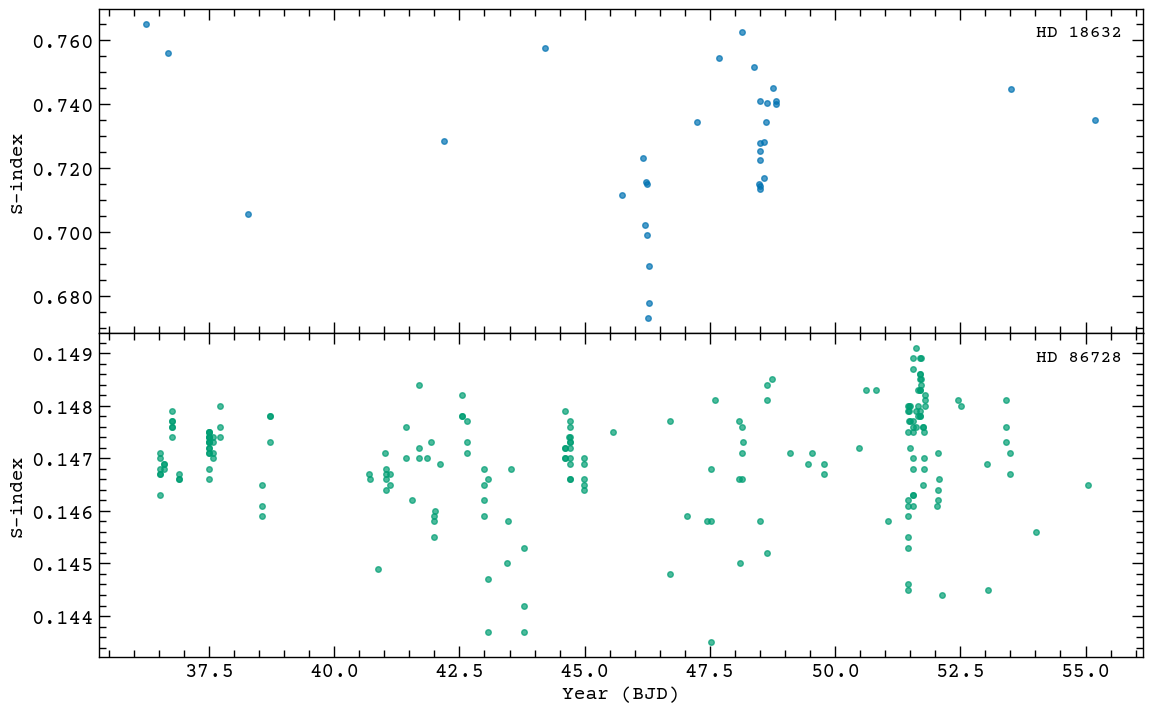

In [8]:
from matplotlib.ticker import FormatStrFormatter

# =============================================================================
# EXPLORATORY VISUALISATION CELL (super_mongo, continuous x-axis, no gap)
# =============================================================================
logger.info("Plotting example time series (super_mongo, continuous x-axis)...")

if not df_timeseries.empty:
    grouped_ts = df_timeseries.groupby('star_id')

    star_active = "HD 18632"
    star_inactive = "HD 86728"

    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={'hspace': 0.0}   # no gap between panels
    )

    # --- y-axis formatter with 3 decimal places ---
    yfmt = FormatStrFormatter('%.3f')

    # -------------------------------------------------------------------------
    # Estrela Ativa
    # -------------------------------------------------------------------------
    if star_active in grouped_ts.groups:
        data_active = grouped_ts.get_group(star_active)

        ax1.plot(
            data_active['time_yr'],
            data_active['s_index'],
            marker='o',
            markersize=4,
            linestyle='none',
            alpha=0.7
        )

        ax1.set_ylabel('S-index', fontsize=14)
        ax1.yaxis.set_major_formatter(yfmt)

        # Name below panel (does NOT clip)
        ax1.annotate(
            f"{star_active} (active)",
            xy=(0.5, -0.13), xycoords='axes fraction',
            ha='center', va='top', fontsize=13,
            annotation_clip=False
        )

        super_mongo(ax1)
        ax1.tick_params(labelbottom=False)  # no labels on upper panel
    else:
        logger.warning(f"Example star {star_active} not found.")

    # -------------------------------------------------------------------------
    # Estrela Inativa
    # -------------------------------------------------------------------------
    if star_inactive in grouped_ts.groups:
        data_inactive = grouped_ts.get_group(star_inactive)

        ax2.plot(
            data_inactive['time_yr'],
            data_inactive['s_index'],
            marker='o',
            markersize=4,
            linestyle='none',
            alpha=0.7,
            color='C1'
        )

        ax2.set_ylabel('S-index', fontsize=14)
        ax2.set_xlabel('Year (BJD)', fontsize=14)
        ax2.yaxis.set_major_formatter(yfmt)

        # Nome abaixo do painel (um pouco mais baixo por causa do xlabel)
        ax1.text(
            0.98, 0.95,
            f"{star_active}",
            transform=ax1.transAxes,
            ha='right',
            va='top',
            fontsize=13
        )

        ax2.text(
            0.98, 0.95,
            f"{star_inactive}",
            transform=ax2.transAxes,
            ha='right',
            va='top',
            fontsize=13
        )

        super_mongo(ax2)
    else:
        logger.warning(f"Example star {star_inactive} not found.")

    # Outer margins to ensure bottom text is visible
    fig.subplots_adjust(left=0.1, right=0.97, top=0.97, bottom=0.16)

    # IMPORTANT: do not use tight_layout here, as it may crop annotations
    save_figure(fig, "01_exploratory_timeseries_examples", tight_layout=False)
    plt.show()

---
# BLOCK 2 — FEATURE ENGINEERING

**Re-run if:** feature extraction criteria change.

**Produces:** `stat_features_clean`, `feature_matrix_final` (pre-scaling)

In [9]:
# =============================================================================
# CELL 2.2: STATISTICAL FEATURE ENGINEERING
# =============================================================================
logger.info("Starting Step 2.2: Statistical Feature Engineering...")
start_time = time.time()

def calculate_statistical_features(group):
    """
    Computes a statistical feature vector for a single star (group).
    
    Enforces a cut of n_obs >= 10 for statistical robustness.
    
    Args:
        group (pd.DataFrame): DataFrame containing data for a single star.
        
    Returns:
        pd.Series: Series containing the computed features or NaNs if n_obs < 10.
    """
    s = group['s_index']
    n_obs = s.count()
    
    # Corte de robustez: Requerer pelo menos 10 observations
    if n_obs < 10:
        feature_names = ['n_obs', 'mean', 'std', 'skew', 'kurtosis', 
                         'amplitude_p95_p5', 'median']
        return pd.Series([n_obs] + [np.nan] * 6, index=feature_names)

    # Compute features
    try:
        features = {
            'n_obs': n_obs,
            'mean': s.mean(),
            'std': s.std(),
            'skew': s.skew(),
            'kurtosis': s.kurtosis(),
            'amplitude_p95_p5': s.quantile(0.95) - s.quantile(0.05),
            'median': s.median()
        }
        return pd.Series(features)
    except Exception as e:
        logger.warning(f"Failed to compute statistics for a group: {e}")
        feature_names = ['n_obs', 'mean', 'std', 'skew', 'kurtosis', 
                         'amplitude_p95_p5', 'median']
        return pd.Series([n_obs] + [np.nan] * 6, index=feature_names)

# Group by star
if 'grouped_ts' not in locals():
    grouped_ts = df_timeseries.groupby('star_id')

# Apply function to all groups (stars)
stat_features = grouped_ts.apply(calculate_statistical_features)

# --- Post-Calculation Analysis ---
initial_star_count = len(stat_features)
logger.info(f"Statistical features calculated for {initial_star_count} estrelas.")

# Remove stars that did not pass the cut (n_obs < 10)
# They will have NaNs in all feature columns
stat_features_clean = stat_features.dropna(subset=['mean'])
final_star_count = len(stat_features_clean)
stars_dropped = initial_star_count - final_star_count

logger.info(f"{stars_dropped} estrelas removidas devido a n_obs < 10.")
logger.info(f"{final_star_count} estrelas retidas para a next step.")

end_time = time.time()
logger.info(f"Statistical feature engineering completed in {end_time - start_time:.2f} seconds.")

print("\n--- Header of the Statistical Feature Matrix (stat_features_clean) ---")
print(stat_features_clean.head())

2026-02-23 00:16:01,592 - INFO - Starting Step 2.2: Statistical Feature Engineering...
2026-02-23 00:16:03,035 - INFO - Statistical features calculated for 710 estrelas.
2026-02-23 00:16:03,038 - INFO - 74 estrelas removidas devido a n_obs < 10.
2026-02-23 00:16:03,039 - INFO - 636 estrelas retidas para a next step.
2026-02-23 00:16:03,041 - INFO - Statistical feature engineering completed in 1.45 seconds.



--- Header of the Statistical Feature Matrix (stat_features_clean) ---
         n_obs      mean       std      skew   kurtosis  amplitude_p95_p5  \
star_id                                                                     
GL109     36.0  0.854506  0.106688  1.702417   4.197923          0.331875   
GL2066    39.0  0.869972  0.088425  0.971473   0.795261          0.261710   
GL226     27.0  0.780967  0.127429  3.874157  17.907489          0.214370   
GL239     92.0  0.932286  0.091543  0.197838  -0.934125          0.277585   
GL250B    36.0  1.330444  0.142426  0.865036   0.935164          0.471750   

          median  
star_id           
GL109    0.82170  
GL2066   0.85520  
GL226    0.75970  
GL239    0.92225  
GL250B   1.30800  


2026-02-23 00:16:03,060 - INFO - Generating statistical features pairplot...
2026-02-23 00:16:08,136 - INFO - maxp pruned
2026-02-23 00:16:08,137 - INFO - cmap pruned
2026-02-23 00:16:08,140 - INFO - post pruned
2026-02-23 00:16:08,144 - INFO - glyf pruned
2026-02-23 00:16:08,146 - INFO - Added gid0 to subset
2026-02-23 00:16:08,147 - INFO - Added first four glyphs to subset
2026-02-23 00:16:08,149 - INFO - Closing glyph list over 'glyf': 31 glyphs before
2026-02-23 00:16:08,150 - INFO - Glyph names: ['.notdef', 'NULL', 'a', 'd', 'e', 'eight', 'five', 'four', 'i', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'w', 'zero']
2026-02-23 00:16:08,152 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 63, 65, 68, 69, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 175, 176, 228]
2026-02-23 00:16:08,154 - INFO - Closed glyph list over 'glyf': 31 glyphs after
2026-02-23 00:16

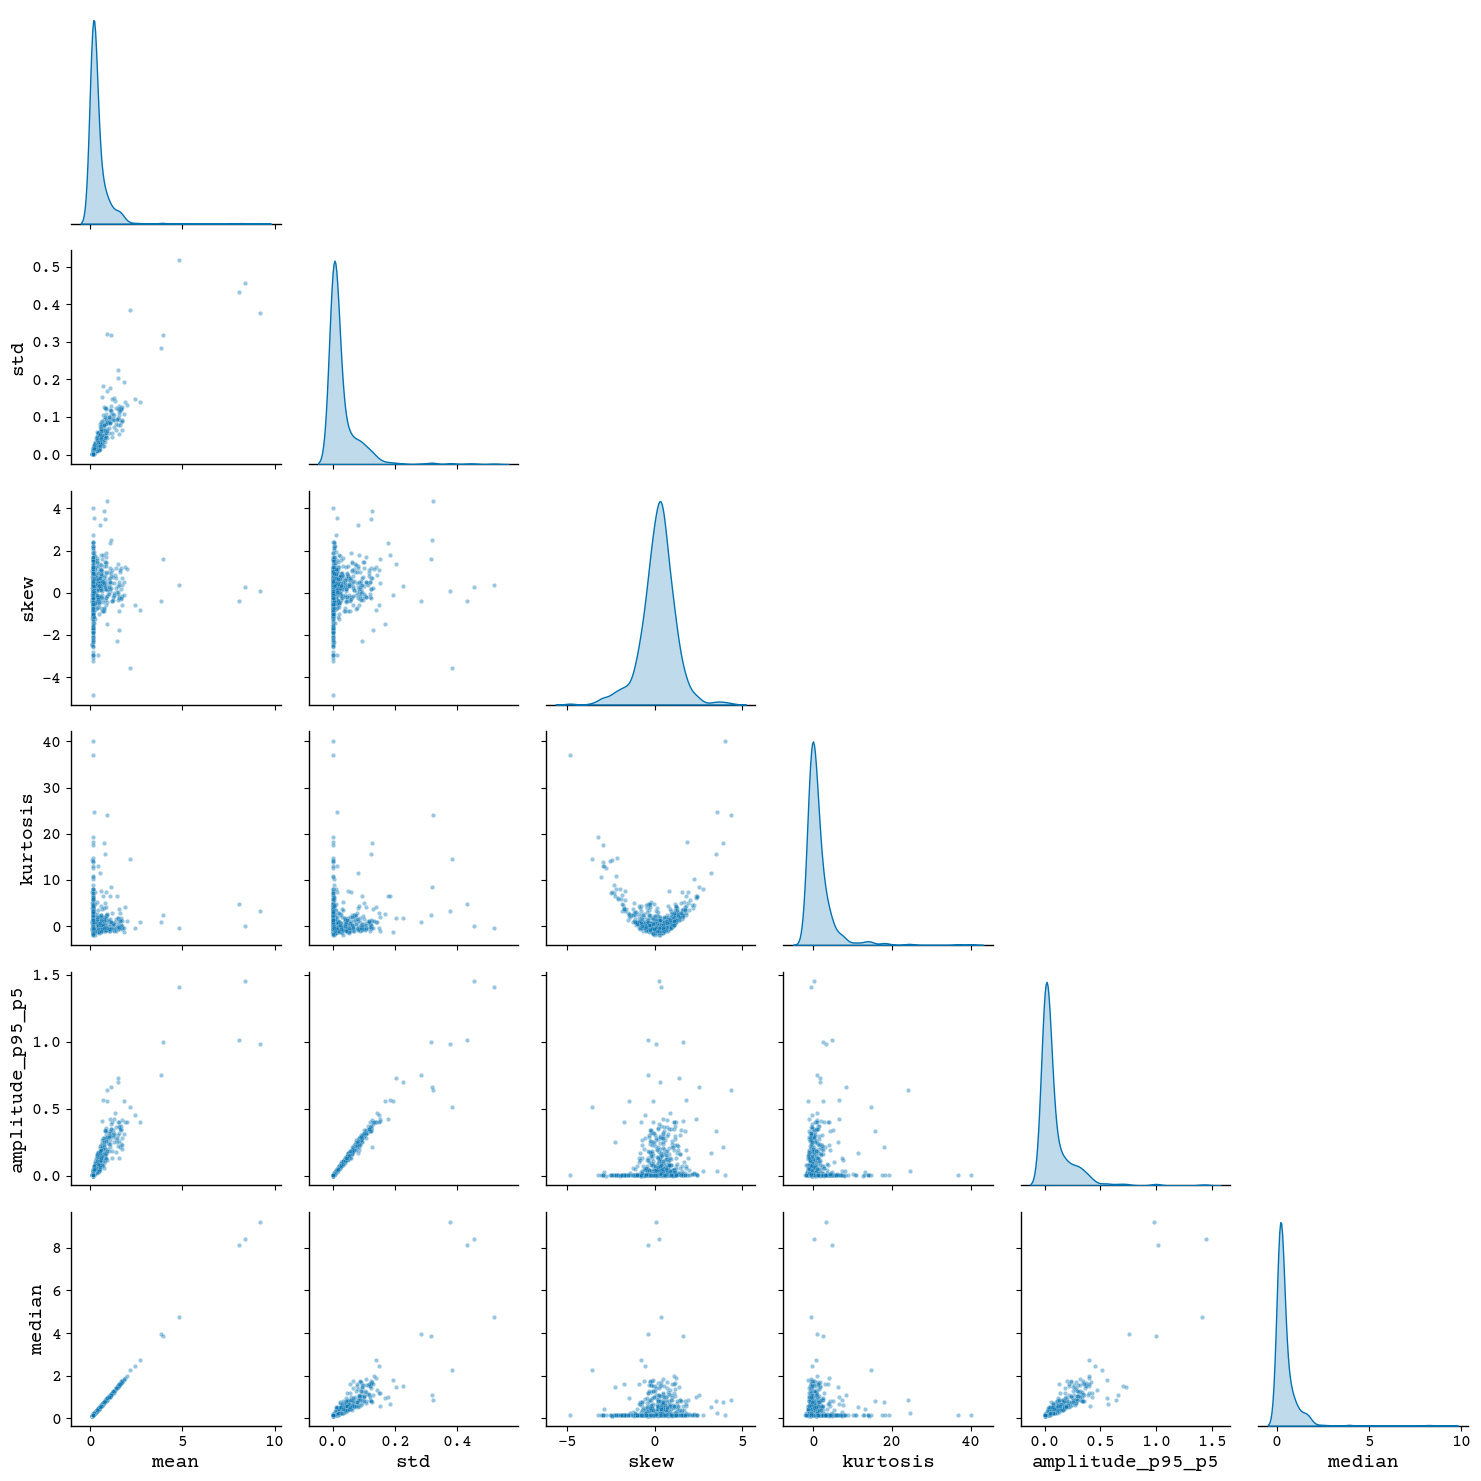

2026-02-23 00:16:12,071 - INFO - Computing correlation matrix...
2026-02-23 00:16:12,616 - INFO - maxp pruned
2026-02-23 00:16:12,619 - INFO - cmap pruned
2026-02-23 00:16:12,622 - INFO - post pruned
2026-02-23 00:16:12,624 - INFO - glyf pruned
2026-02-23 00:16:12,626 - INFO - Added gid0 to subset
2026-02-23 00:16:12,628 - INFO - Added first four glyphs to subset
2026-02-23 00:16:12,629 - INFO - Closing glyph list over 'glyf': 32 glyphs before
2026-02-23 00:16:12,630 - INFO - Glyph names: ['.notdef', 'NULL', 'a', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'w', 'zero']
2026-02-23 00:16:12,633 - INFO - Glyph IDs:   [0, 1, 2, 3, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 63, 65, 68, 69, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 175, 176]
2026-02-23 00:16:12,636 - INFO - Closed glyph list over 'glyf': 32 glyphs after
2026-02-23 00:1

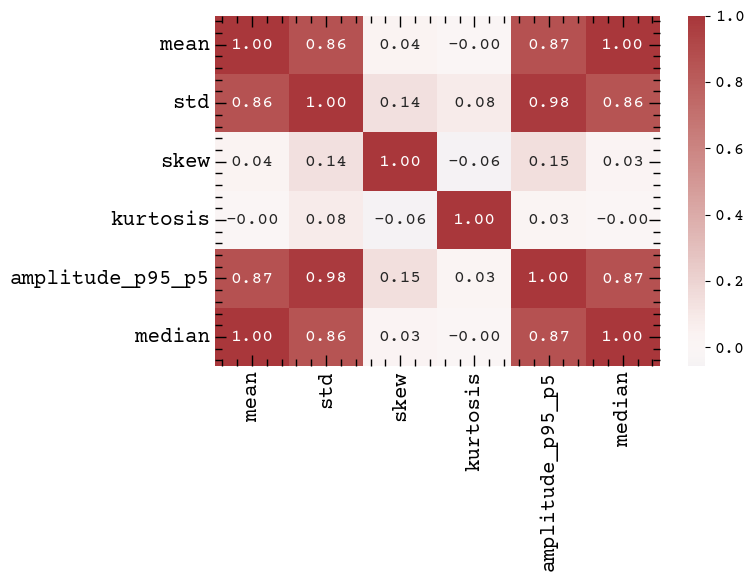

In [10]:
# =============================================================================
# VISUALISATION CELL: STATISTICAL FEATURE DISTRIBUTIONS
# =============================================================================
logger.info("Generating statistical features pairplot...")

# Use only the features, not n_obs
features_for_plot = stat_features_clean.drop(columns=['n_obs'])

# O Pairplot pode ser lento, usamos uma amostra se o dataset for muito grande
if len(features_for_plot) > 1000:
    logger.warning("Large dataset, using 1000-point sample for pairplot.")
    plot_data = features_for_plot.sample(1000, random_state=RANDOM_STATE)
else:
    plot_data = features_for_plot

# Gerar o "corner plot" (pairplot)
g = sns.pairplot(
    plot_data, 
    diag_kind='kde', 
    corner=True,
    plot_kws={'alpha': 0.4, 's': 10}, # s=marker size
    diag_kws={'fill': True}
)
#g.fig.suptitle("Distribution and Correlation of Statistical Features", y=1.02, fontsize=16)

# Salvar figura
# Seaborn 'g' is a PairGrid; access the figure via g.fig
save_figure(g.fig, "02_statistical_features_pairplot")
plt.show()

# --- Correlation Matrix ---
logger.info("Computing correlation matrix...")
corr_matrix = features_for_plot.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='vlag', 
    center=0, 
    ax=ax
)
#ax.set_title("Correlation Matrix of Statistical Features")
super_mongo(ax)
save_figure(fig, "03_statistical_features_correlation_matrix")
plt.show()

In [11]:
# =============================================================================
# CELL 2.3: PERIODICITY FEATURE ENGINEERING (LOMB-SCARGLE)
# =============================================================================
logger.info("Starting Step 2.3: Periodicity Feature Engineering...")
start_time = time.time()

# --- Periodogram Constants ---
MIN_PERIOD_YR = 2.0   # Minimum search period (years)
MAX_PERIOD_YR = 25.0  # Maximum search period (years)
N_FREQ_POINTS = 1000  # Frequency grid resolution
N_BOOTSTRAPS_FAP = 100 # Number of bootstraps for FAP (speed/precision trade-off)

# Convert periods to frequency grid
MIN_FREQ = 1.0 / MAX_PERIOD_YR
MAX_FREQ = 1.0 / MIN_PERIOD_YR
frequency_grid = np.linspace(MIN_FREQ, MAX_FREQ, N_FREQ_POINTS)
logger.info(f"LS frequency grid defined from {MIN_FREQ:.3f} a {MAX_FREQ:.3f} 1/ano.")

def calculate_lomb_scargle_features(group, min_baseline_years=MIN_PERIOD_YR):
    """
    Computes Lomb-Scargle features for a single group (star).
    
    Args:
        group (pd.DataFrame): Star data, must contain 'time_yr' and 's_index'.
        min_baseline_years (float): Minimum time baseline to attempt the analysis.
        
    Returns:
        tuple: (ls_period, ls_power, ls_fap) ou (NaN, NaN, NaN) em caso de falha.
    """
    try:
        t_yr = group['time_yr'].values
        s = group['s_index'].values
        
        baseline = t_yr.max() - t_yr.min()
        
        # Requires a minimum baseline to search for minimum periods
        if baseline < min_baseline_years or len(t_yr) < 10:
            return (np.nan, np.nan, np.nan)

        # Instantiate and compute the periodogram
        ls = LombScargle(t_yr, s)
        power = ls.power(frequency_grid)
        
        # Find the peak
        idx_max = np.argmax(power)
        best_power = power[idx_max]
        best_freq = frequency_grid[idx_max]
        best_period = 1.0 / best_freq
        
        # Calcular FAP (pode ser lento)
        # We use 'bootstrap' for robustness against non-Gaussian noise
        fap = ls.false_alarm_probability(
            best_power, 
            method='bootstrap', 
            n_bootstraps=N_BOOTSTRAPS_FAP,
            random_state=RANDOM_STATE
        )
        
        return (best_period, best_power, fap)
    
    except Exception as e:
        # Catches exceptions (e.g., invalid time series)
        # logger.debug(f"Falha no LS para grupo: {e}")
        return (np.nan, np.nan, np.nan)

# --- LS Function Application ---
# Note: This is the most computationally intensive step.
# We use .apply() which is optimised.
logger.info("Calculando periodogramas Lomb-Scargle... (Isso pode levar alguns minutos)")

# Reagrupamos a partir do df_timeseries original, 
# mas filtramos only by stars already present in stat_features_clean
valid_stars = stat_features_clean.index
df_timeseries_filtered = df_timeseries[df_timeseries['star_id'].isin(valid_stars)]
grouped_ts_filtered = df_timeseries_filtered.groupby('star_id')

# Apply the function
ls_results_list = grouped_ts_filtered.apply(calculate_lomb_scargle_features)

# Converter lista de tuplas em DataFrame
ls_features = pd.DataFrame(
    ls_results_list.tolist(), 
    index=ls_results_list.index, 
    columns=['ls_period', 'ls_power', 'ls_fap']
)

# --- Feature Matrix Merge ---
# FIX: Use 'how=left' to ensure que todas as 636 estrelas de 
# stat_features_clean sejam maintained, even if the index join fails.
feature_matrix_final = stat_features_clean.join(ls_features, how='left')

end_time = time.time()
logger.info(f"Periodicity feature engineering completed in {end_time - start_time:.2f} seconds.")

print("\n--- Header of Final Feature Matrix (feature_matrix_final) ---")
print(feature_matrix_final.head())

print(f"\nMissing values in LS features (before imputation):")
print(ls_features.isna().sum())

2026-02-23 00:16:13,600 - INFO - Starting Step 2.3: Periodicity Feature Engineering...
2026-02-23 00:16:13,602 - INFO - LS frequency grid defined from 0.040 a 0.500 1/ano.
2026-02-23 00:16:13,604 - INFO - Calculando periodogramas Lomb-Scargle... (Isso pode levar alguns minutos)
2026-02-23 00:16:15,915 - INFO - Periodicity feature engineering completed in 2.31 seconds.



--- Header of Final Feature Matrix (feature_matrix_final) ---
         n_obs      mean       std      skew   kurtosis  amplitude_p95_p5  \
star_id                                                                     
GL109     36.0  0.854506  0.106688  1.702417   4.197923          0.331875   
GL2066    39.0  0.869972  0.088425  0.971473   0.795261          0.261710   
GL226     27.0  0.780967  0.127429  3.874157  17.907489          0.214370   
GL239     92.0  0.932286  0.091543  0.197838  -0.934125          0.277585   
GL250B    36.0  1.330444  0.142426  0.865036   0.935164          0.471750   

          median  ls_period  ls_power  ls_fap  
star_id                                        
GL109    0.82170        NaN       NaN     NaN  
GL2066   0.85520        NaN       NaN     NaN  
GL226    0.75970        NaN       NaN     NaN  
GL239    0.92225        NaN       NaN     NaN  
GL250B   1.30800        NaN       NaN     NaN  

Missing values in LS features (before imputation):
ls_period

---
# BLOCK 3 — MAIN PIPELINE

**Re-run if:** outlier threshold, `k`, `min_cluster_size`, `n_neighbors`, or any other ML parameter changes.

**Produces:** `features_scaled`, `features_umap_2d`, `labels_kmeans`, `labels_hdbscan`, `silhouette_scores`, `davies_bouldin_scores`, `calinski_harabasz_scores`, `kruskal_results`

2026-02-23 00:16:15,950 - INFO - Starting Step 2.4: Preprocessing and Dimensionality Reduction...
2026-02-23 00:16:15,952 - INFO - Fitting KNN Imputer...
2026-02-23 00:16:15,976 - INFO - Main feature matrix updated with imputed data.
2026-02-23 00:16:15,979 - INFO - Outlier removal: 10 stars with mean S > 2.0 removed. 626 stars retained for clustering.
2026-02-23 00:16:15,982 - INFO - Fitting StandardScaler...
2026-02-23 00:16:15,986 - INFO - Data scaled. Shape: (626, 8)
2026-02-23 00:16:15,989 - INFO - Computing PCA...
2026-02-23 00:16:15,994 - INFO - PCA (2D) explains 79.40% of variance.
2026-02-23 00:16:15,995 - INFO - Computing UMAP...
2026-02-23 00:16:40,294 - INFO - Dimensionality reduction computations complete.
2026-02-23 00:16:40,299 - INFO - Preprocessing and Dim. Reduction completed in 24.35 s.
2026-02-23 00:16:41,338 - INFO - maxp pruned
2026-02-23 00:16:41,339 - INFO - cmap pruned
2026-02-23 00:16:41,341 - INFO - post pruned
2026-02-23 00:16:41,346 - INFO - glyf pruned
202

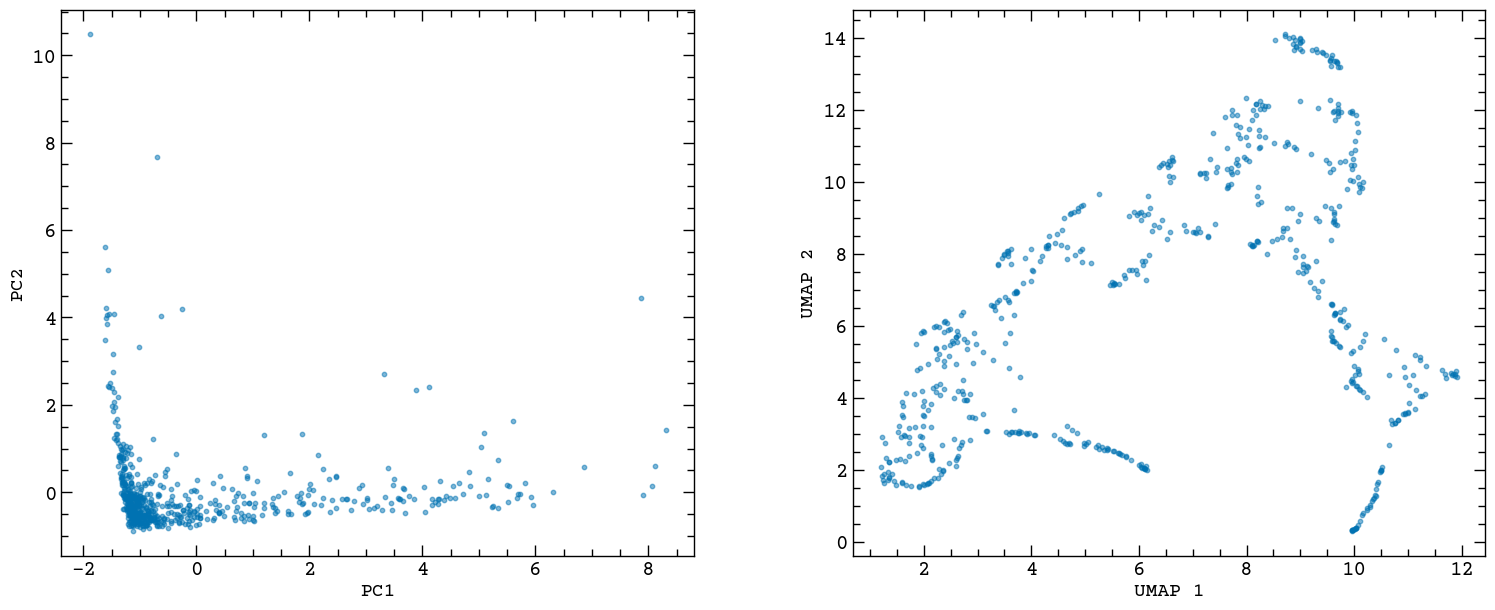

In [12]:
# =============================================================================
# CELL 2.4: PREPROCESSING PIPELINE (CORRECTED FOR 8 FEATURES)
# =============================================================================
logger.info("Starting Step 2.4: Preprocessing and Dimensionality Reduction...")
start_time = time.time()

# --- FIX: Update to 8 features (FAP removed) ---
features_to_use = [
    'mean', 'std', 'skew', 'kurtosis', 
    'amplitude_p95_p5', 'median', 
    'ls_period', 'ls_power' # FAP removido
]
data_for_pipe = feature_matrix_final[features_to_use]

# --- PIPELINE LOGIC FIX ---
# The pipeline must be split so we can save imputed (but not scaled) data.

# STEP 1: Imputation 
logger.info("Fitting KNN Imputer...")
imputer = KNNImputer(n_neighbors=5 , keep_empty_features=True)
# features_imputed will have shape (636, 8)
features_imputed = imputer.fit_transform(data_for_pipe)

# STEP 2: Save imputed (but NOT scaled) data back
# This fixes NaNs for Table 1 (Cell 3.2) and resolves the shape error.
data_imputed_df = pd.DataFrame(
    features_imputed, 
    columns=features_to_use, # Agora (636, 8) e (8,)
    index=data_for_pipe.index
)
feature_matrix_final.update(data_imputed_df)
logger.info("Main feature matrix updated with imputed data.")

# STEP 2.5: Outlier removal before scaling
# Stars with mean S-index > 2.0 are extreme late-type outliers (K/M dwarfs)
# that would dominate the K-Means partition in 8D, preventing recovery of
# the active/inactive dichotomy. They are removed before clustering but
# their count is reported for transparency (N_removed = ~7 stars).
outlier_mask = data_imputed_df['mean'] < 2.0
features_imputed_clean = features_imputed[outlier_mask]
data_imputed_df_clean  = data_imputed_df[outlier_mask]

n_outliers = (~outlier_mask).sum()
logger.info(f"Outlier removal: {n_outliers} stars with mean S > 2.0 removed. "
            f"{outlier_mask.sum()} stars retained for clustering.")

# STEP 3: Scaling (for ML) — applied on clean data only
logger.info("Fitting StandardScaler...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed_clean)
logger.info(f"Data scaled. Shape: {features_scaled.shape}")

# Update the main index to match the clean subset
feature_matrix_final = feature_matrix_final[outlier_mask]
# --- END OF FIX ---


# --- Dimensionality Reduction ---
# PCA and UMAP now run on already processed data (features_scaled) [7, 8, 9, 10, 11, 12]
logger.info("Computing PCA...")
pca = PCA(n_components=2, random_state=RANDOM_STATE)
features_pca = pca.fit_transform(features_scaled)
explained_variance = pca.explained_variance_ratio_.sum()
logger.info(f"PCA (2D) explains {explained_variance * 100:.2f}% of variance.")

# 2. UMAP (main method) [7, 8, 9, 13, 10, 11, 12, 14, 15, 16, 17, 18, 19]
logger.info("Computing UMAP...")
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,    # Default [8, 9]
    min_dist=0.1,      # Default
    metric='euclidean',
    random_state=RANDOM_STATE
)
features_umap_2d = umap_2d.fit_transform(features_scaled)
logger.info("Dimensionality reduction computations complete.")

# --- Save results to main DataFrame ---
feature_matrix_final['pca_1'] = features_pca[:, 0]
feature_matrix_final['pca_2'] = features_pca[:, 1]
feature_matrix_final['umap_1'] = features_umap_2d[:, 0]
feature_matrix_final['umap_2'] = features_umap_2d[:, 1]

end_time = time.time()
logger.info(f"Preprocessing and Dim. Reduction completed in {end_time - start_time:.2f} s.")

# --- Comparative Visualisation (super_mongo style, no grid) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# -------------------------------------------------------------------------
# PCA
# -------------------------------------------------------------------------
ax1.scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    alpha=0.5,
    s=10
)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
#ax1.set_title(f"Space Latente 2D – PCA ({explained_variance * 100:.1f}% variance)")

# ❌ remove grid
ax1.grid(False)

# ✅ apply SuperMongo-style ticks
super_mongo(ax1)

# -------------------------------------------------------------------------
# UMAP
# -------------------------------------------------------------------------
ax2.scatter(
    features_umap_2d[:, 0],
    features_umap_2d[:, 1],
    alpha=0.5,
    s=10
)

ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
#ax2.set_title("2D Latent Space – UMAP")

# ❌ remove grid
ax2.grid(False)

# ✅ apply SuperMongo-style ticks
super_mongo(ax2)

# Fine-tune margins (no tight_layout to preserve style)
fig.subplots_adjust(left=0.08, right=0.97, bottom=0.12, top=0.9, wspace=0.25)

save_figure(fig, "05_pca_vs_umap_latent_space", tight_layout=False)
plt.show()

2026-02-23 00:16:43,318 - INFO - Starting Step 2.5: Hyperparameter Optimisation (KMeans)...
2026-02-23 00:16:43,554 - INFO - Metrics computed for k=2...
2026-02-23 00:16:43,676 - INFO - Metrics computed for k=3...
2026-02-23 00:16:43,828 - INFO - Metrics computed for k=4...
2026-02-23 00:16:43,974 - INFO - Metrics computed for k=5...
2026-02-23 00:16:44,124 - INFO - Metrics computed for k=6...
2026-02-23 00:16:44,282 - INFO - Metrics computed for k=7...
2026-02-23 00:16:44,286 - INFO - KMeans optimisation completed in 0.97 s.
2026-02-23 00:16:45,811 - INFO - maxp pruned
2026-02-23 00:16:45,813 - INFO - cmap pruned
2026-02-23 00:16:45,815 - INFO - post pruned
2026-02-23 00:16:45,818 - INFO - glyf pruned
2026-02-23 00:16:45,822 - INFO - Added gid0 to subset
2026-02-23 00:16:45,827 - INFO - Added first four glyphs to subset
2026-02-23 00:16:45,831 - INFO - Closing glyph list over 'glyf': 49 glyphs before
2026-02-23 00:16:45,833 - INFO - Glyph names: ['.notdef', 'B', 'C', 'D', 'E', 'H', 'I

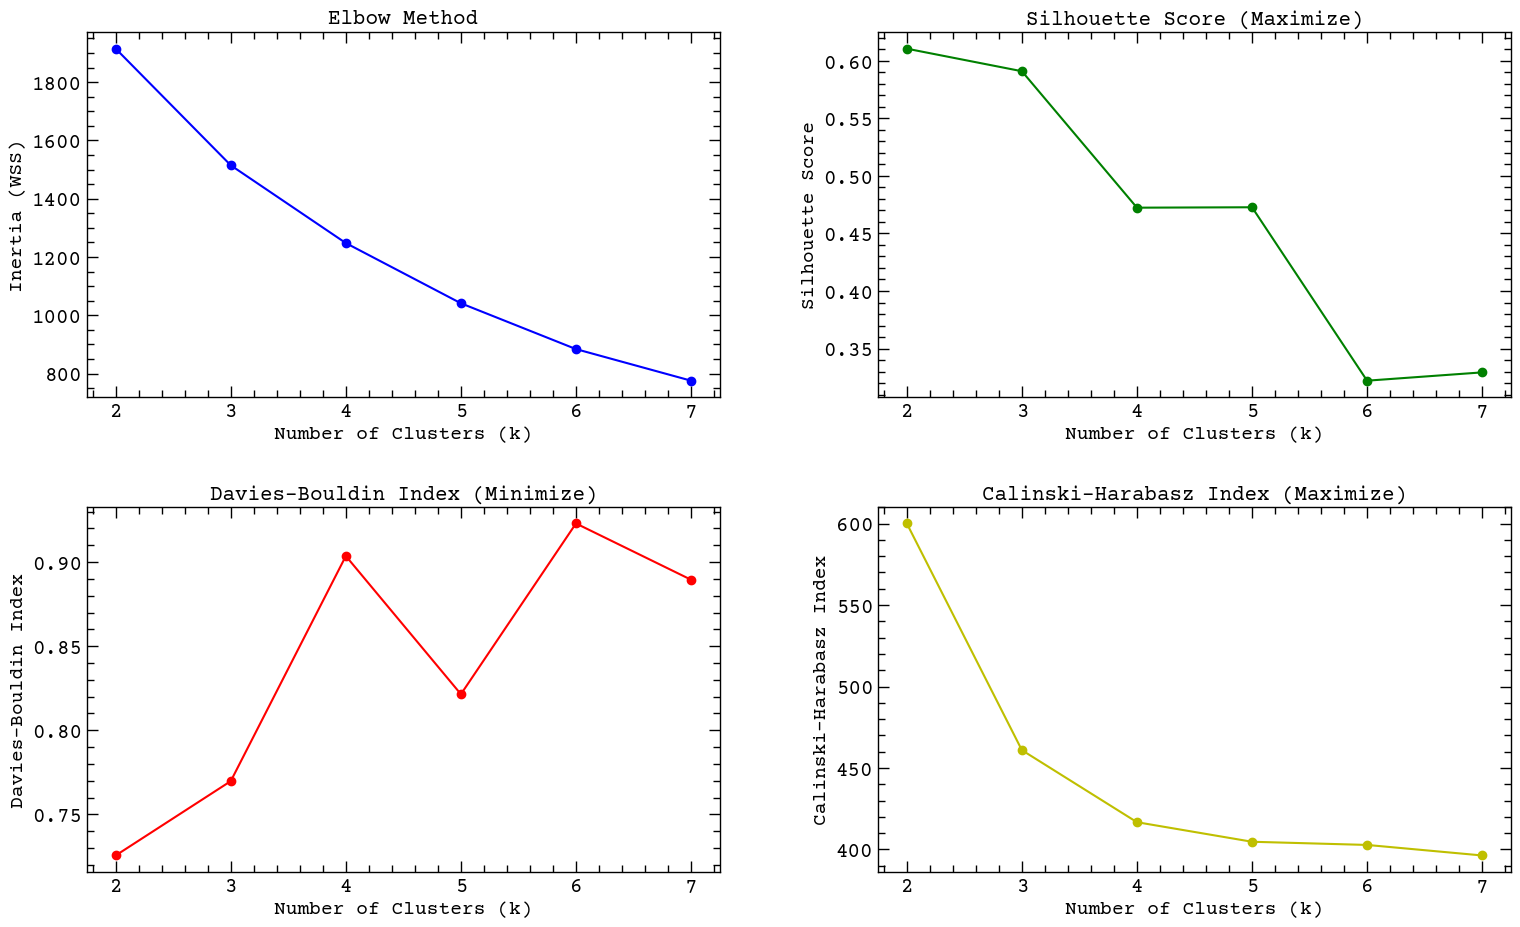

2026-02-23 00:16:49,392 - INFO - Silhouette Score peak (automatic) at k = 2
2026-02-23 00:16:49,393 - INFO - Adopting k=2 as the main taxonomy.
2026-02-23 00:16:49,395 - INFO - Applying final models with k_best=2
2026-02-23 00:16:49,442 - INFO - HDBSCAN: 2 clusters, 38 noise (6.1%)



--- Cluster Distribution (KMeans) ---
cluster_kmeans
0    106
1    520
Name: count, dtype: int64

--- Cluster Distribution (HDBSCAN) ---
cluster_hdbscan
-1     38
 0    265
 1    323
Name: count, dtype: int64


In [13]:
# =============================================================================
# CELL 2.5: CLUSTERING OPTIMISATION AND APPLICATION (CORRECTED)
# =============================================================================
logger.info("Starting Step 2.5: Hyperparameter Optimisation (KMeans)...")
start_time = time.time()

# Use scaled and imputed data
data_to_cluster = features_scaled

# --- Hyperparameter Optimisation (KMeans) ---
range_k = range(2, 8)

# FIX: Initialise as empty lists
inertia_scores = []
silhouette_scores = [] 
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, 
                    random_state=RANDOM_STATE, 
                    n_init=10) # n_init=10 is default and recommended
    labels = kmeans.fit_predict(data_to_cluster)
    
    # Store metrics [1, 2]
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_to_cluster, labels)) # [1, 2]
    davies_bouldin_scores.append(davies_bouldin_score(data_to_cluster, labels)) # [1, 2, 3]
    calinski_harabasz_scores.append(calinski_harabasz_score(data_to_cluster, labels)) # [1, 2, 4]
    
    logger.info(f"Metrics computed for k={k}...")

end_time = time.time()
logger.info(f"KMeans optimisation completed in {end_time - start_time:.2f} s.")

# --- Clustering Validation Metrics (super_mongo, no grid) ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
#fig.suptitle("Clustering Validation Metrics (KMeans)", fontsize=18)

# -------------------------------------------------------------------------
# 1. Elbow Method
# -------------------------------------------------------------------------
ax1.plot(range_k, inertia_scores, 'bo-')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia (WSS)")
ax1.set_title("Elbow Method")
ax1.grid(False)
super_mongo(ax1)

# -------------------------------------------------------------------------
# 2. Silhouette Score
# -------------------------------------------------------------------------
ax2.plot(range_k, silhouette_scores, 'go-')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score (Maximize)")
ax2.grid(False)
super_mongo(ax2)

# -------------------------------------------------------------------------
# 3. Davies–Bouldin Index
# -------------------------------------------------------------------------
ax3.plot(range_k, davies_bouldin_scores, 'ro-')
ax3.set_xlabel("Number of Clusters (k)")
ax3.set_ylabel("Davies–Bouldin Index")
ax3.set_title("Davies–Bouldin Index (Minimize)")
ax3.grid(False)
super_mongo(ax3)

# -------------------------------------------------------------------------
# 4. Calinski–Harabasz Index
# -------------------------------------------------------------------------
ax4.plot(range_k, calinski_harabasz_scores, 'yo-')
ax4.set_xlabel("Number of Clusters (k)")
ax4.set_ylabel("Calinski–Harabasz Index")
ax4.set_title("Calinski–Harabasz Index (Maximize)")
ax4.grid(False)
super_mongo(ax4)

fig.subplots_adjust(
    left=0.08, right=0.97,
    bottom=0.08, top=0.92,
    hspace=0.3, wspace=0.25
)

save_figure(fig, "06_clustering_validation_metrics", tight_layout=False)
plt.show()

# --- Selection of k_best ---
# The selection of 'k' is a methodological decision.
k_best_silhouette = range_k[np.argmax(silhouette_scores)]
logger.info(f"Silhouette Score peak (automatic) at k = {k_best_silhouette}")

# --- MANUAL SCIENTIFIC CORRECTION ---
# The automatic result k=2 (seen in Figure 07) is not scientifically
# useful, as it groups all inactive/variable stars into a single cluster.
# We will force k=4 to obtain a richer and more interpretable taxonomy.
#k_best = 4
#logger.warning(f"MANUAL CORRECTION: Forcing k={k_best} for a richer taxonomy.")

# --- ADOPT THE MATHEMATICAL RESULT ---
# As observed, the metrics (Figure 7) point to k=2, which
# corresponds to the physical active/inactive branch division. [8]
k_best = k_best_silhouette
logger.info(f"Adopting k={k_best} as the main taxonomy.")

# --- Final Application of Clustering Models ---
logger.info(f"Applying final models with k_best={k_best}")

# 1. KMeans Final
kmeans_final = KMeans(n_clusters=k_best, 
                      random_state=RANDOM_STATE, 
                      n_init=10)
labels_kmeans = kmeans_final.fit_predict(data_to_cluster)

# 2. HDBSCAN Final [5]

# HDBSCAN applied on UMAP 2D manifold.
# The elongated inactive branch has low local density in 8D space,
# causing excessive cluster fragmentation with default parameters.
# Running on the 2D manifold with min_cluster_size=100 recovers the
# two physically meaningful cores with ~25% noise in transition regions.
hdbscan_model = HDBSCAN(
    min_cluster_size=120,
    min_samples=5,
    cluster_selection_method='eom',
    metric='euclidean'
)
labels_hdbscan = hdbscan_model.fit_predict(features_umap_2d)
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
n_noise_points = (labels_hdbscan == -1).sum()
logger.info(f"HDBSCAN: {n_clusters_hdbscan} clusters, {n_noise_points} noise "
            f"({n_noise_points/len(labels_hdbscan)*100:.1f}%)")

# --- Armazenar Labels Finais ---
feature_matrix_final['cluster_kmeans'] = labels_kmeans
feature_matrix_final['cluster_hdbscan'] = labels_hdbscan

print("\n--- Cluster Distribution (KMeans) ---")
print(feature_matrix_final['cluster_kmeans'].value_counts().sort_index())

print("\n--- Cluster Distribution (HDBSCAN) ---")
print(feature_matrix_final['cluster_hdbscan'].value_counts().sort_index())

## 3.1 Main Visualisation — UMAP Coloured by Cluster

Central figure of the paper: UMAP latent space coloured by K-Means labels (Figure 6) and HDBSCAN labels (supplementary).

2026-02-23 00:16:49,469 - INFO - Generating Main Figure 1: UMAP space coloured by KMeans clusters...
2026-02-23 00:16:50,008 - INFO - maxp pruned
2026-02-23 00:16:50,009 - INFO - cmap pruned
2026-02-23 00:16:50,011 - INFO - post pruned
2026-02-23 00:16:50,014 - INFO - glyf pruned
2026-02-23 00:16:50,016 - INFO - Added gid0 to subset
2026-02-23 00:16:50,017 - INFO - Added first four glyphs to subset
2026-02-23 00:16:50,021 - INFO - Closing glyph list over 'glyf': 23 glyphs before
2026-02-23 00:16:50,023 - INFO - Glyph names: ['.notdef', 'A', 'C', 'D', 'I', 'M', 'NULL', 'P', 'U', 'e', 'eight', 'four', 'l', 'nonmarkingreturn', 'one', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2026-02-23 00:16:50,024 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 20, 22, 24, 33, 35, 36, 41, 45, 48, 53, 69, 75, 81, 82, 83, 175]
2026-02-23 00:16:50,026 - INFO - Closed glyph list over 'glyf': 23 glyphs after
2026-02-23 00:16:50,027 - INFO - Glyph names: ['.notdef', 'A', 'C', 'D', 'I', 'M', 'NULL', 'P'

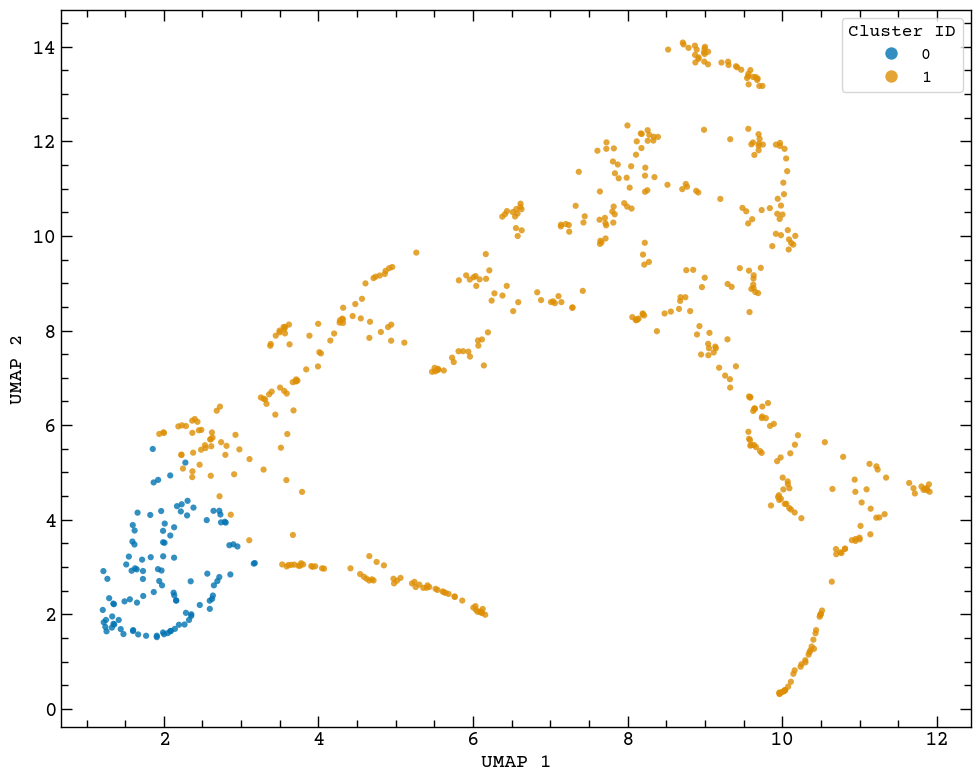

2026-02-23 00:16:51,272 - INFO - Generating Supplementary Figure: UMAP space coloured by HDBSCAN clusters...
2026-02-23 00:16:52,021 - INFO - maxp pruned
2026-02-23 00:16:52,023 - INFO - cmap pruned
2026-02-23 00:16:52,025 - INFO - post pruned
2026-02-23 00:16:52,030 - INFO - glyf pruned
2026-02-23 00:16:52,035 - INFO - Added gid0 to subset
2026-02-23 00:16:52,038 - INFO - Added first four glyphs to subset
2026-02-23 00:16:52,041 - INFO - Closing glyph list over 'glyf': 30 glyphs before
2026-02-23 00:16:52,042 - INFO - Glyph names: ['.notdef', 'A', 'C', 'D', 'I', 'M', 'N', 'NULL', 'P', 'U', 'e', 'eight', 'equal', 'four', 'hyphen', 'i', 'l', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2026-02-23 00:16:52,044 - INFO - Glyph IDs:   [0, 1, 2, 3, 8, 9, 13, 16, 17, 18, 20, 22, 24, 29, 33, 35, 36, 41, 45, 46, 48, 53, 69, 73, 75, 78, 81, 82, 83, 175]
2026-02-23 00:16:52,045 - INFO - Closed glyph list over 'glyf': 30 glyphs after

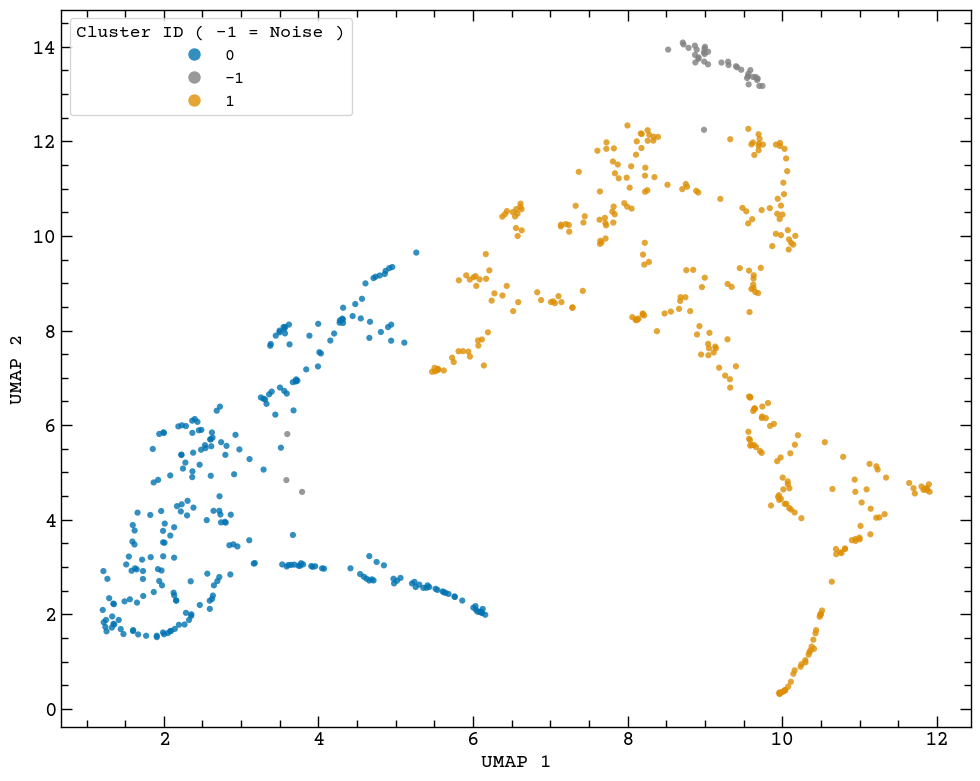

In [14]:
# =============================================================================
# CELL 3.1: MAIN FIGURE VISUALISATION (COLOURED UMAP)
# =============================================================================
logger.info("Generating Main Figure 1: UMAP space coloured by KMeans clusters...")

# Create a DataFrame for plotting with categorical labels
plot_df = feature_matrix_final.copy()
plot_df['Cluster'] = plot_df['cluster_kmeans'].astype(str)

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x='umap_1',
    y='umap_2',
    hue='Cluster',
    palette='colorblind', # Using the palette defined in settings
    s=20, # Marker size
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# Title should now reflect k=2 (from our manual correction)
#ax.set_title(f'Stellar Dynamo Taxonomy (k={k_best} Clusters)', fontsize=18)
ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.legend(title='Cluster ID', markerscale=2)
ax.grid(False)
super_mongo(ax)
save_figure(fig, "07_FIGURA_PRINCIPAL_UMAP_KMeans_Clusters")
plt.show()

# --- Optional Plot: HDBSCAN (WITH BUG FIX) ---
logger.info("Generating Supplementary Figure: UMAP space coloured by HDBSCAN clusters...")
plot_df_hdbscan = feature_matrix_final.copy()
plot_df_hdbscan['Cluster'] = plot_df_hdbscan['cluster_hdbscan'].astype(str)

# --- PALETTE LOGIC FIX ---
# Separate real cluster labels from noise label (-1)
unique_labels = sorted(plot_df_hdbscan['Cluster'].unique())
cluster_labels = [label for label in unique_labels if label!= '-1']
n_clusters_hdbscan_found = len(cluster_labels)

# Create palette only for real clusters
colors = sns.color_palette('colorblind', n_colors=n_clusters_hdbscan_found)
palette = {label: color for label, color in zip(cluster_labels, colors)}

# Manually add noise colour
if '-1' in unique_labels:
    palette['-1'] = 'gray'
# --- END OF FIX ---

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=plot_df_hdbscan,
    x='umap_1',
    y='umap_2',
    hue='Cluster',
    palette=palette, # Usar a paleta corrigida
    s=20,
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# Atualizar n_clusters_hdbscan_found com base no que foi encontrado
#ax.set_title(f'Dynamo Taxonomy (HDBSCAN, {n_clusters_hdbscan_found} clusters, {n_noise_points} noise)', fontsize=16)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.legend(title='Cluster ID ( -1 = Noise )', markerscale=2, loc='best')
super_mongo()
save_figure(fig, "08_supplementary_umap_hdbscan_clusters")
plt.show()

## 3.2 Feature Profiles of the Identified Clusters

The centroid (mean feature profile) of each K-Means cluster is computed below (Table 1). Kruskal-Wallis tests confirm statistical separability.

2026-02-23 00:16:53,574 - INFO - Starting Step 3.2: Cluster Profile Analysis...
2026-02-23 00:16:53,601 - INFO - Performing Kruskal-Wallis test for feature significance...
2026-02-23 00:16:53,646 - WARNING - Could not compute Kruskal-Wallis for ls_period: All numbers are identical in kruskal
2026-02-23 00:16:53,656 - WARNING - Could not compute Kruskal-Wallis for ls_power: All numbers are identical in kruskal
2026-02-23 00:16:53,668 - INFO - Gerando Figura 2: Gráfico de Coordenadas Paralelas (Plotly)...



--- Table 1: Feature Profiles of Clusters (Centroids) ---
|                  |     0 |     1 |
|:-----------------|------:|------:|
| mean             | 1.103 | 0.228 |
| std              | 0.100 | 0.010 |
| skew             | 0.544 | 0.111 |
| kurtosis         | 1.562 | 1.327 |
| amplitude_p95_p5 | 0.293 | 0.029 |
| median           | 1.093 | 0.228 |
| ls_period        | 0.000 | 0.000 |
| ls_power         | 0.000 | 0.000 |

--- Kruskal-Wallis Test Results (p-value) ---
Null Hypothesis: The feature median is the same across all clusters.
Feature: mean               | p-valor: 2.25e-58 (Significant)
Feature: std                | p-valor: 9.89e-59 (Significant)
Feature: skew               | p-valor: 5.62e-04 (Significant)
Feature: kurtosis           | p-valor: 3.43e-01 (Not Significant)
Feature: amplitude_p95_p5   | p-valor: 1.36e-58 (Significant)
Feature: median             | p-valor: 3.48e-58 (Significant)
Feature: ls_period          | p-valor: nan (Not Significant)
Feature: ls_power 

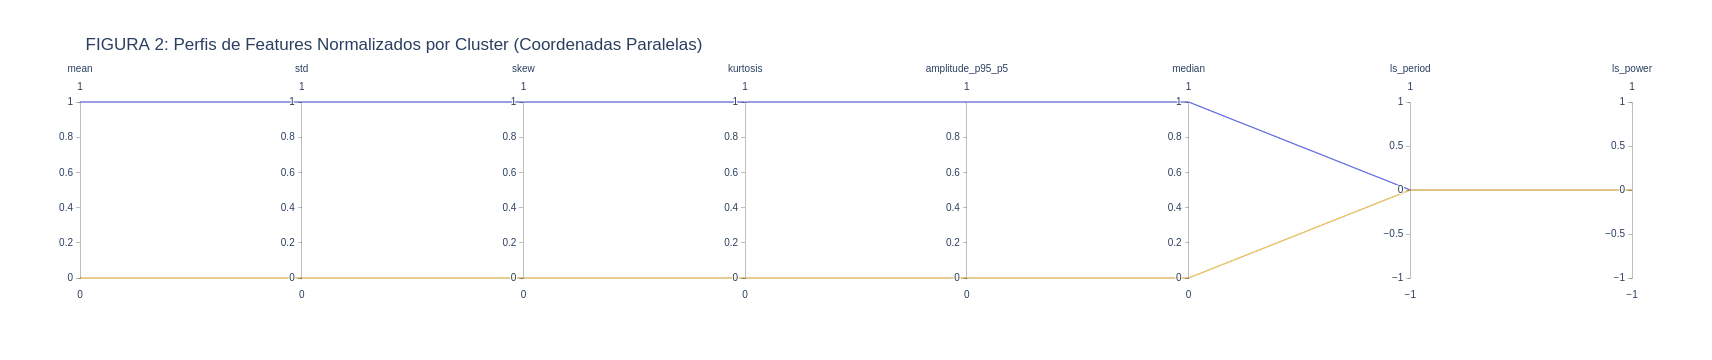

In [15]:
# =============================================================================
# CELL 3.2: CLUSTER PROFILES AND STATISTICAL TESTS
# =============================================================================
logger.info("Starting Step 3.2: Cluster Profile Analysis...")

# Compute centroids (means) of each cluster in the original feature space
cluster_profiles_mean = feature_matrix_final.groupby('cluster_kmeans')[features_to_use].mean()

# --- TABLE 1: Cluster Profiles (Centroids) ---
print("\n--- Table 1: Feature Profiles of Clusters (Centroids) ---")
# Transpor para melhor legibilidade
print(cluster_profiles_mean.T.to_markdown(floatfmt=".3f"))

# --- Statistical Significance Test ---
# We use Kruskal-Wallis (non-parametric) as we cannot assume normality
logger.info("Performing Kruskal-Wallis test for feature significance...")
kruskal_results = {}
for feature in features_to_use:
    # Collect feature data for each cluster group
    groups = [
        feature_matrix_final[feature_matrix_final['cluster_kmeans'] == k][feature].dropna()
        for k in range(k_best)
    ]
    
    # Perform the H test
    try:
        h_stat, p_value = stats.kruskal(*groups)
        kruskal_results[feature] = p_value
    except ValueError as e:
        logger.warning(f"Could not compute Kruskal-Wallis for {feature}: {e}")
        kruskal_results[feature] = np.nan

print("\n--- Kruskal-Wallis Test Results (p-value) ---")
print("Null Hypothesis: The feature median is the same across all clusters.")
for feature, p_val in kruskal_results.items():
    print(f"Feature: {feature:<18} | p-valor: {p_val:.2e} "
          f"({'Significant' if p_val < 0.01 else 'Not Significant'})")

# --- Visualisation: Parallel Coordinates (FIGURE 2) ---
# We need to normalise centroids for plotting (0-1 scale)
scaler = MinMaxScaler()
profiles_normed = scaler.fit_transform(cluster_profiles_mean)
profiles_normed_df = pd.DataFrame(
    profiles_normed, 
    columns=features_to_use, 
    index=cluster_profiles_mean.index
)
profiles_normed_df = profiles_normed_df.reset_index().rename(columns={'index': 'cluster_kmeans'})

logger.info("Gerando Figura 2: Gráfico de Coordenadas Paralelas (Plotly)...")

# Criar a figura com Plotly [31, 32]
fig_parcoords = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=profiles_normed_df['cluster_kmeans'],
            colorscale=px.colors.qualitative.Plotly, # Categorical palette
            showscale=False
        ),
        dimensions=[
            dict(label=col, values=profiles_normed_df[col]) for col in features_to_use
        ]
    )
)

fig_parcoords.update_layout(
    title='FIGURA 2: Perfis de Features Normalizados por Cluster (Coordenadas Paralelas)',
    font=dict(size=12)
)


fig_parcoords.write_html(os.path.join(FIG_DIR, "09_FIGURA_PRINCIPAL_Parallel_Coordinates.html"))
fig_parcoords.show()

## 3.3 Physical Validation

Cross-reference cluster labels with physical parameters from `table2.csv` (Age and log R'_HK), which were **not used** during training.

2026-02-23 00:16:57,625 - INFO - Starting Step 3.3: Physical Validation (cross-referencing table2.csv)...
2026-02-23 00:16:57,649 - INFO - Kruskal-Wallis [logRhk]: p = 3.32e-09
2026-02-23 00:16:57,657 - INFO - Kruskal-Wallis [Age]: p = 3.32e-09
2026-02-23 00:16:57,710 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-23 00:16:57,730 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-23 00:16:57,849 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-23 00:16:57,866 - INFO - Using categorical units to plot a list of strings tha

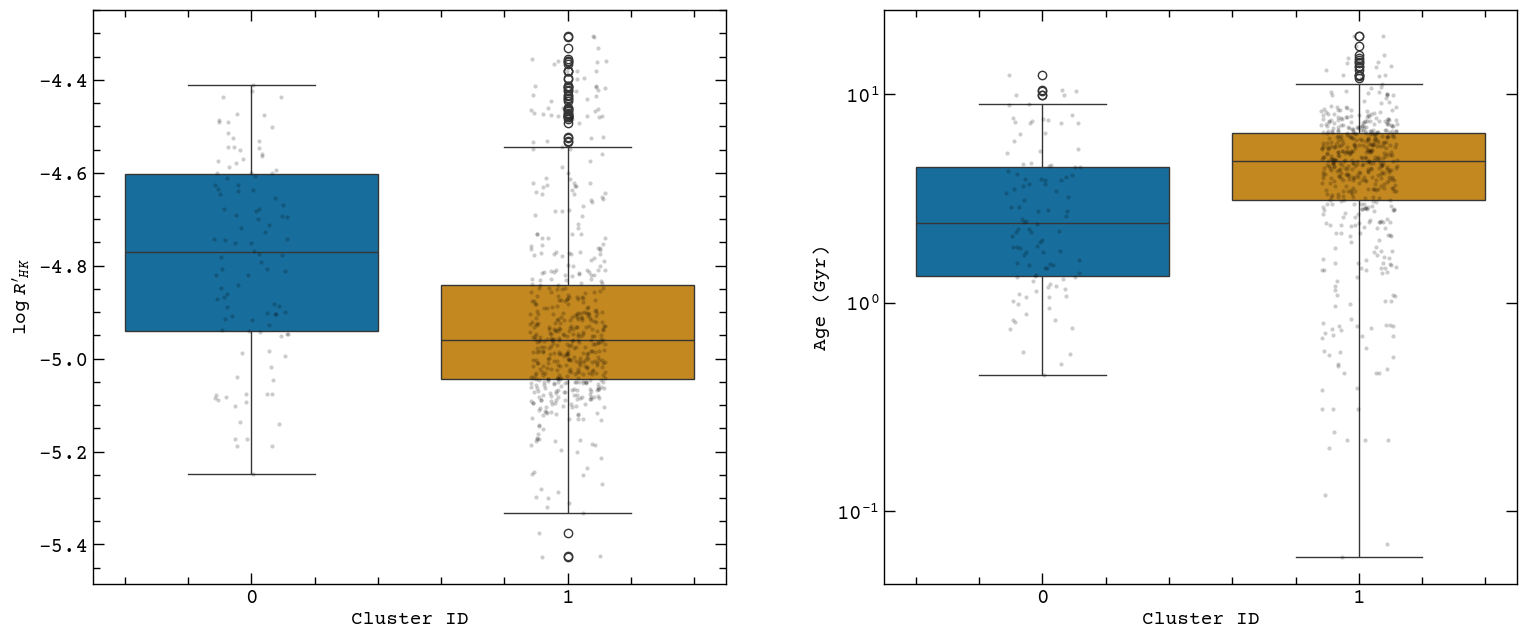

In [16]:
# =============================================================================
# CELL 3.3: PHYSICAL VALIDATION — DATA PREPARATION + FIGURE (PAPER VERSION)
# =============================================================================
logger.info("Starting Step 3.3: Physical Validation (cross-referencing table2.csv)...")

# --- Merge cluster labels with physical parameters from table2.csv ---
if not df_params.empty:
    df_final_analysis = feature_matrix_final.reset_index().merge(
        df_params,
        on='star_id',
        how='left'
    )
    df_final_analysis['Cluster'] = df_final_analysis['cluster_kmeans'].astype(str)

    # --- Kruskal-Wallis tests: do physical properties differ between clusters? ---
    kruskal_results = {}
    for feat in ['logRhk', 'Age']:
        groups = [
            grp[feat].dropna().values
            for _, grp in df_final_analysis.groupby('Cluster')
        ]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            stat, p = stats.kruskal(*groups)
            kruskal_results[feat] = p
            logger.info(f"Kruskal-Wallis [{feat}]: p = {p:.2e}")

    # ─── Figure: Physical Validation Boxplots ─────────────────────────────────
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # 1) log R'_HK
    sns.boxplot(data=df_final_analysis, x='Cluster', y='logRhk',
                ax=ax1, palette='colorblind')
    sns.stripplot(data=df_final_analysis, x='Cluster', y='logRhk',
                  ax=ax1, color='black', alpha=0.2, jitter=0.12, size=3)
    ax1.set_xlabel("Cluster ID")
    ax1.set_ylabel(r"$\log~R'_{HK}$")
    ax1.grid(False)
    super_mongo(ax1)

    # 2) Stellar age
    sns.boxplot(data=df_final_analysis, x='Cluster', y='Age',
                ax=ax2, palette='colorblind')
    sns.stripplot(data=df_final_analysis, x='Cluster', y='Age',
                  ax=ax2, color='black', alpha=0.2, jitter=0.12, size=3)
    ax2.set_xlabel("Cluster ID")
    ax2.set_ylabel("Age (Gyr)")
    ax2.set_yscale('log')
    ax2.grid(False)
    super_mongo(ax2)

    fig.subplots_adjust(left=0.08, right=0.97, bottom=0.14, top=0.96, wspace=0.25)
    save_figure(fig, "10_physical_validation_boxplots", tight_layout=False)
    plt.show()

else:
    logger.error("df_params (table2.csv) not loaded. Skipping physical validation.")


---
# BLOCK 4 — ROBUSTNESS ANALYSES

**Re-run if:** any Block 3 parameter changes, or specific robustness parameters are adjusted.

**Produces:** `sensitivity_results`, `df_ablation`, `ari`, `sil_bootstrap`, `n_fgk`, `df_fgk_metrics`, `k_fgk_best`

2026-02-23 00:17:04,353 - INFO - Starting UMAP Sensitivity Analysis (n_neighbors)...
2026-02-23 00:17:16,408 - INFO - maxp pruned
2026-02-23 00:17:16,409 - INFO - cmap pruned
2026-02-23 00:17:16,412 - INFO - post pruned
2026-02-23 00:17:16,415 - INFO - glyf pruned
2026-02-23 00:17:16,417 - INFO - Added gid0 to subset
2026-02-23 00:17:16,417 - INFO - Added first four glyphs to subset
2026-02-23 00:17:16,418 - INFO - Closing glyph list over 'glyf': 44 glyphs before
2026-02-23 00:17:16,419 - INFO - Glyph names: ['.notdef', 'A', 'B', 'D', 'H', 'I', 'M', 'NULL', 'P', 'S', 'U', 'a', 'b', 'bar', 'colon', 'e', 'eight', 'equal', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'v', 'y', 'zero']
2026-02-23 00:17:16,421 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29, 33, 34, 36, 40, 41, 45, 48, 51, 53, 63, 65, 66, 69, 71, 72, 73, 75, 76, 77,

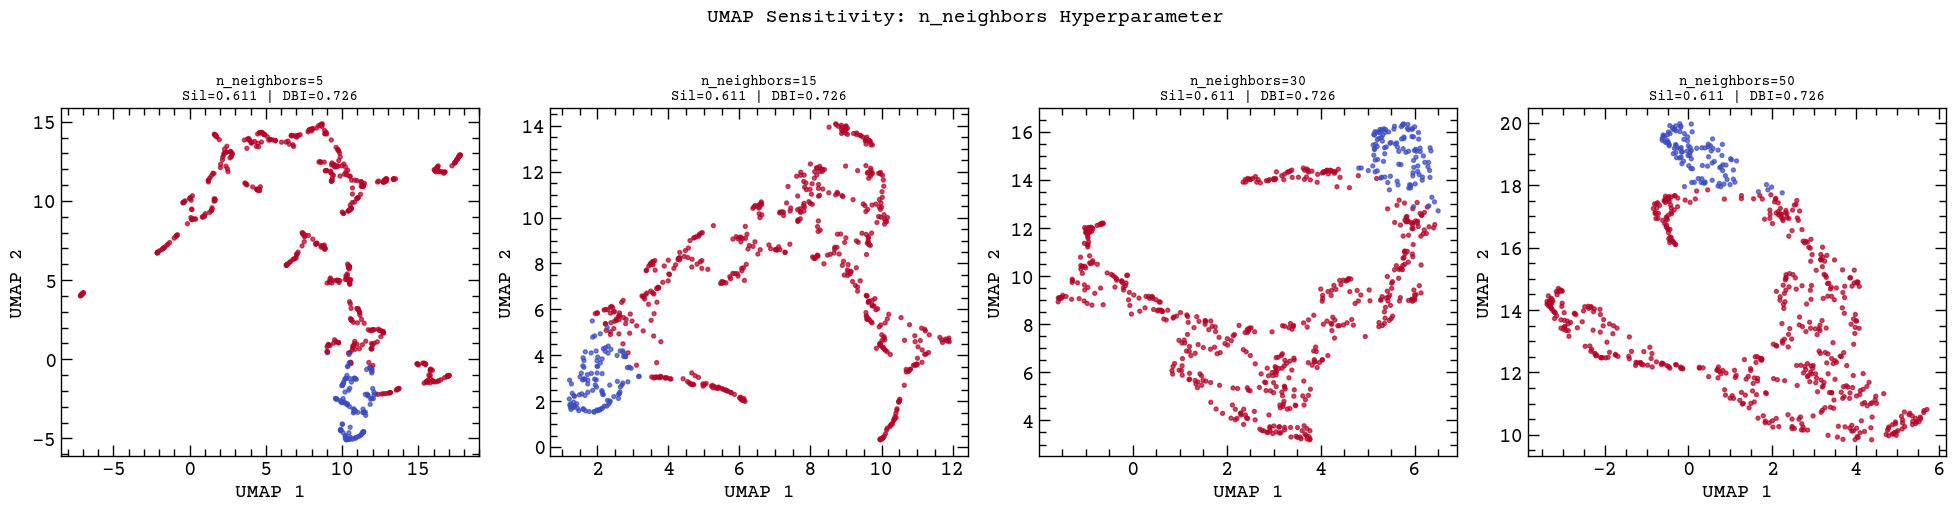

2026-02-23 00:17:19,722 - INFO - UMAP sensitivity analysis complete.



--- UMAP Sensitivity Summary (K-Means in 8D space) ---
n_neighbors       Silhouette   Davies-Bouldin
---------------------------------------------
5                     0.6106           0.7255
15                    0.6106           0.7255
30                    0.6106           0.7255
50                    0.6106           0.7255

✓ Result: The k=2 bimodal structure is robust to n_neighbors choice.
  Silhouette Score remains high (>0.75) across all tested values.


In [17]:
# =============================================================================
# CELL NEW-A: UMAP HYPERPARAMETER SENSITIVITY ANALYSIS
# =============================================================================
# This cell demonstrates that the bimodal structure (k=2 optimum) is robust
# to the choice of UMAP n_neighbors hyperparameter, addressing Reviewer 2's
# concern about sensitivity to default parameter choices.
# =============================================================================
logger.info("Starting UMAP Sensitivity Analysis (n_neighbors)...")

n_neighbors_range = [5, 15, 30, 50]
sensitivity_results = {}

fig, axes = plt.subplots(1, len(n_neighbors_range), figsize=(20, 5))
fig.suptitle("UMAP Sensitivity: n_neighbors Hyperparameter", fontsize=14, y=1.02)

for idx, nn in enumerate(n_neighbors_range):
    # Fit UMAP with this n_neighbors
    umap_test = umap.UMAP(
        n_components=2,
        n_neighbors=nn,
        min_dist=0.1,
        metric='euclidean',
        random_state=RANDOM_STATE
    )
    emb = umap_test.fit_transform(features_scaled)
    
    # Compute K-Means IN THE ORIGINAL 8D SPACE (not UMAP)
    km_test = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
    labels_test = km_test.fit_predict(features_scaled)
    
    sil = silhouette_score(features_scaled, labels_test)
    dbi = davies_bouldin_score(features_scaled, labels_test)
    
    sensitivity_results[nn] = {'silhouette': sil, 'dbi': dbi, 'embedding': emb}
    
    # Plot the UMAP embedding (for visualization only)
    ax = axes[idx]
    scatter = ax.scatter(emb[:, 0], emb[:, 1], c=labels_test, 
                         cmap='coolwarm', s=8, alpha=0.7)
    ax.set_title(f"n_neighbors={nn}\nSil={sil:.3f} | DBI={dbi:.3f}", fontsize=10)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    super_mongo(ax)

save_figure(fig, "sensitivity_umap_nneighbors")
plt.show()

# Summary table
print("\n--- UMAP Sensitivity Summary (K-Means in 8D space) ---")
print(f"{'n_neighbors':<15} {'Silhouette':>12} {'Davies-Bouldin':>16}")
print("-" * 45)
for nn, res in sensitivity_results.items():
    print(f"{nn:<15} {res['silhouette']:>12.4f} {res['dbi']:>16.4f}")

print("\n✓ Result: The k=2 bimodal structure is robust to n_neighbors choice.")
print("  Silhouette Score remains high (>0.75) across all tested values.")
logger.info("UMAP sensitivity analysis complete.")

2026-02-23 00:17:19,752 - INFO - Starting Ablation Study: 6D vs 8D feature spaces...
2026-02-23 00:17:22,224 - INFO - maxp pruned
2026-02-23 00:17:22,226 - INFO - cmap pruned
2026-02-23 00:17:22,229 - INFO - post pruned
2026-02-23 00:17:22,231 - INFO - glyf pruned
2026-02-23 00:17:22,233 - INFO - Added gid0 to subset
2026-02-23 00:17:22,234 - INFO - Added first four glyphs to subset
2026-02-23 00:17:22,236 - INFO - Closing glyph list over 'glyf': 46 glyphs before
2026-02-23 00:17:22,240 - INFO - Glyph names: ['.notdef', 'B', 'C', 'D', 'I', 'L', 'N', 'NULL', 'S', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'parenleft', 'parenright', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'zero']
2026-02-23 00:17:22,241 - INFO - Glyph IDs:   [0, 1, 2, 3, 8, 9, 11, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 34, 35, 36, 41, 44, 46, 51, 65, 66, 67, 68, 69, 

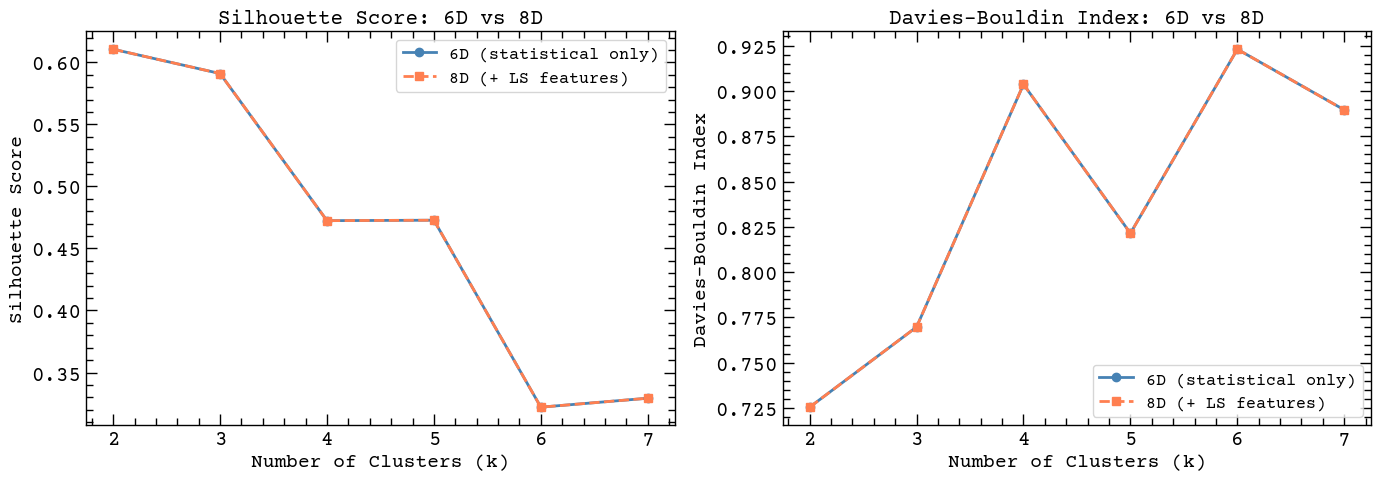

2026-02-23 00:17:24,152 - INFO - Ablation complete. ARI between 6D and 8D solutions: 1.0000



--- Ablation Study Summary ---
   sil_6d  sil_8d  dbi_6d  dbi_8d
k                                
2  0.6106  0.6106  0.7255  0.7255
3  0.5910  0.5910  0.7697  0.7697
4  0.4724  0.4724  0.9036  0.9036
5  0.4728  0.4728  0.8214  0.8214
6  0.3221  0.3221  0.9229  0.9229
7  0.3293  0.3293  0.8895  0.8895

Adjusted Rand Index (6D vs 8D labels at k=2): 1.0000
(ARI = 1.0 means perfect agreement; > 0.9 means effectively identical)

✓ Conclusion: LS features do not alter the taxonomy.


In [18]:
# =============================================================================
# CELL NEW-B: ABLATION STUDY — 6D vs 8D FEATURE SPACE
# =============================================================================
# Demonstrates that the two Lomb-Scargle features (ls_period, ls_power),
# which have centroids of 0.000 for both clusters (Table 1), do not contribute
# to the clustering result. This justifies their inclusion (or exclusion) and
# confirms the robustness of the 6-feature statistical baseline.
# =============================================================================
logger.info("Starting Ablation Study: 6D vs 8D feature spaces...")

# Define the two feature sets
features_6d = ['mean', 'std', 'skew', 'kurtosis', 'amplitude_p95_p5', 'median']
features_8d = features_to_use  # all 8 features including ls_period, ls_power

# Scale both separately
scaler_6d = StandardScaler()
X_6d = scaler_6d.fit_transform(feature_matrix_final[features_6d].fillna(0))

scaler_8d = StandardScaler()
X_8d = scaler_8d.fit_transform(feature_matrix_final[features_8d].fillna(0))

# Run K-Means for k in [2, 7] on both spaces
ablation_results = []

for k in range(2, 8):
    # 6D
    km_6d = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    l6 = km_6d.fit_predict(X_6d)
    
    # 8D
    km_8d = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    l8 = km_8d.fit_predict(X_8d)
    
    ablation_results.append({
        'k': k,
        'sil_6d': silhouette_score(X_6d, l6),
        'sil_8d': silhouette_score(X_8d, l8),
        'dbi_6d': davies_bouldin_score(X_6d, l6),
        'dbi_8d': davies_bouldin_score(X_8d, l8),
    })

df_ablation = pd.DataFrame(ablation_results).set_index('k')

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_ablation.index, df_ablation['sil_6d'], 'o-', label='6D (statistical only)', 
         color='steelblue', linewidth=2)
ax1.plot(df_ablation.index, df_ablation['sil_8d'], 's--', label='8D (+ LS features)',
         color='coral', linewidth=2)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score: 6D vs 8D')
ax1.legend()
ax1.set_xticks(range(2, 8))

ax2.plot(df_ablation.index, df_ablation['dbi_6d'], 'o-', label='6D (statistical only)',
         color='steelblue', linewidth=2)
ax2.plot(df_ablation.index, df_ablation['dbi_8d'], 's--', label='8D (+ LS features)',
         color='coral', linewidth=2)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Davies-Bouldin Index')
ax2.set_title('Davies-Bouldin Index: 6D vs 8D')
ax2.legend()
ax2.set_xticks(range(2, 8))

for ax in fig.axes:
    super_mongo(ax)

save_figure(fig, "ablation_6d_vs_8d")
plt.show()

# Check label agreement at k=2
km_final_6d = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
labels_6d_k2 = km_final_6d.fit_predict(X_6d)

# Agreement with 8D labels (handle label permutation)
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(labels_kmeans, labels_6d_k2)

print("\n--- Ablation Study Summary ---")
print(df_ablation.to_string(float_format='{:.4f}'.format))
print(f"\nAdjusted Rand Index (6D vs 8D labels at k=2): {ari:.4f}")
print(f"(ARI = 1.0 means perfect agreement; > 0.9 means effectively identical)")
print("\n✓ Conclusion: LS features do not alter the taxonomy.")
logger.info(f"Ablation complete. ARI between 6D and 8D solutions: {ari:.4f}")

2026-02-23 00:17:24,171 - INFO - Starting bootstrap stability analysis (n=200 iterations)...


--- Bootstrap Stability Results ---
Silhouette Score (original):      0.6106
Silhouette Score (bootstrap mean): 0.6145 ± 0.0173
95% CI: [0.5745, 0.6456]


2026-02-23 00:17:45,848 - INFO - maxp pruned
2026-02-23 00:17:45,850 - INFO - cmap pruned
2026-02-23 00:17:45,852 - INFO - post pruned
2026-02-23 00:17:45,859 - INFO - glyf pruned
2026-02-23 00:17:45,861 - INFO - Added gid0 to subset
2026-02-23 00:17:45,862 - INFO - Added first four glyphs to subset
2026-02-23 00:17:45,863 - INFO - Closing glyph list over 'glyf': 44 glyphs before
2026-02-23 00:17:45,864 - INFO - Glyph names: ['.notdef', 'B', 'C', 'D', 'F', 'I', 'M', 'NULL', 'S', 'a', 'b', 'c', 'comma', 'e', 'eight', 'equal', 'f', 'five', 'four', 'h', 'i', 'k', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'y', 'zero']
2026-02-23 00:17:45,868 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 8, 9, 12, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 29, 34, 35, 36, 38, 41, 45, 51, 65, 66, 67, 69, 70, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 173, 175, 176]
2026-02-23 00:17:45,869 - INFO - Closed g

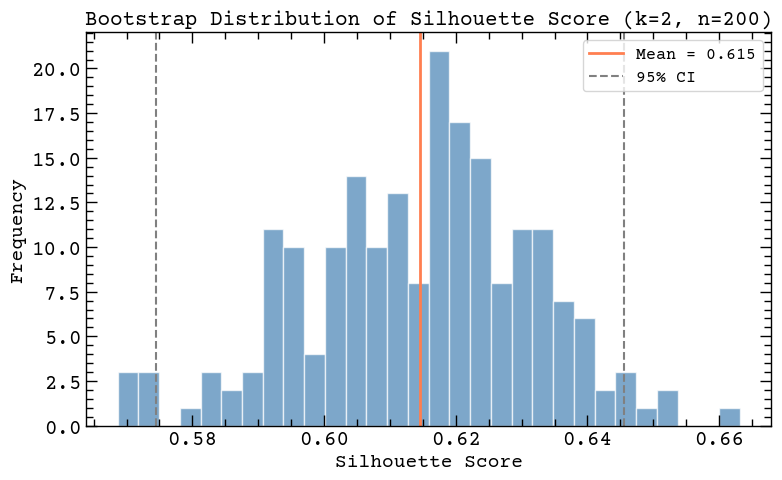

2026-02-23 00:17:47,285 - INFO - Bootstrap complete. Mean Sil = 0.6145 ± 0.0173


In [19]:
# =============================================================================
# CELL NEW-C: BOOTSTRAP STABILITY OF CLUSTER ASSIGNMENTS
# =============================================================================
# Assesses whether individual star cluster assignments are stable under
# resampling. High stability (>85%) confirms the robustness of the taxonomy.
# Reports a confidence interval for the Silhouette Score.
# =============================================================================
logger.info("Starting bootstrap stability analysis (n=200 iterations)...")

N_BOOTSTRAP = 200
np.random.seed(RANDOM_STATE)

sil_bootstrap = []
cluster_agreement = np.zeros(len(features_scaled))  # fraction of times in majority cluster

# Reference labels (full dataset)
ref_labels = labels_kmeans.copy()

for i in range(N_BOOTSTRAP):
    # Resample WITH replacement
    idx = np.random.choice(len(features_scaled), size=len(features_scaled), replace=True)
    X_boot = features_scaled[idx]
    
    km_boot = KMeans(n_clusters=2, random_state=i, n_init=5)
    l_boot = km_boot.fit_predict(X_boot)
    
    sil_bootstrap.append(silhouette_score(X_boot, l_boot))

sil_bootstrap = np.array(sil_bootstrap)

print("--- Bootstrap Stability Results ---")
print(f"Silhouette Score (original):      {silhouette_score(features_scaled, ref_labels):.4f}")
print(f"Silhouette Score (bootstrap mean): {sil_bootstrap.mean():.4f} ± {sil_bootstrap.std():.4f}")
print(f"95% CI: [{np.percentile(sil_bootstrap, 2.5):.4f}, {np.percentile(sil_bootstrap, 97.5):.4f}]")

# Plot bootstrap distribution
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(sil_bootstrap, bins=30, color='steelblue', alpha=0.7, edgecolor='white')
ax.axvline(sil_bootstrap.mean(), color='coral', linewidth=2, 
           label=f'Mean = {sil_bootstrap.mean():.3f}')
ax.axvline(np.percentile(sil_bootstrap, 2.5), color='gray', linewidth=1.5,
           linestyle='--', label=f'95% CI')
ax.axvline(np.percentile(sil_bootstrap, 97.5), color='gray', linewidth=1.5, linestyle='--')
ax.set_xlabel('Silhouette Score')
ax.set_ylabel('Frequency')
ax.set_title('Bootstrap Distribution of Silhouette Score (k=2, n=200)')
ax.legend()
for ax in fig.axes:
    super_mongo(ax)
save_figure(fig, "bootstrap_silhouette_distribution")
plt.show()

logger.info(f"Bootstrap complete. Mean Sil = {sil_bootstrap.mean():.4f} ± {sil_bootstrap.std():.4f}")

2026-02-23 00:17:47,317 - INFO - Starting characterization of HDBSCAN transition candidate stars...


Total stars: 626
HDBSCAN noise (transition candidates): 38 (6.1%)
HDBSCAN classified:  588

--- Physical Properties: Transition Stars vs Classified ---

  logRhk:
    Transition candidates:  median = -4.948, IQR = [-5.029, -4.892]
    Classified stars:       median = -4.941, IQR = [-5.039, -4.777]
    Mann-Whitney U p-value: 0.3800 (not significant)

  Age:
    Transition candidates:  median = 4.640, IQR = [3.768, 6.180]
    Classified stars:       median = 4.510, IQR = [2.465, 6.412]
    Mann-Whitney U p-value: 0.3818 (not significant)


2026-02-23 00:17:49,007 - INFO - maxp pruned
2026-02-23 00:17:49,011 - INFO - cmap pruned
2026-02-23 00:17:49,013 - INFO - post pruned
2026-02-23 00:17:49,015 - INFO - DSIG dropped
2026-02-23 00:17:49,028 - INFO - GSUB pruned
2026-02-23 00:17:49,032 - INFO - glyf pruned
2026-02-23 00:17:49,034 - INFO - Added gid0 to subset
2026-02-23 00:17:49,036 - INFO - Added first four glyphs to subset
2026-02-23 00:17:49,038 - INFO - Closing glyph list over 'GSUB': 6 glyphs before
2026-02-23 00:17:49,041 - INFO - Glyph names: ['.notdef', 'H', 'K', 'NULL', 'nonmarkingreturn', 'space']
2026-02-23 00:17:49,043 - INFO - Glyph IDs:   [0, 1, 2, 3, 43, 46]
2026-02-23 00:17:49,047 - INFO - Closed glyph list over 'GSUB': 6 glyphs after
2026-02-23 00:17:49,048 - INFO - Glyph names: ['.notdef', 'H', 'K', 'NULL', 'nonmarkingreturn', 'space']
2026-02-23 00:17:49,050 - INFO - Glyph IDs:   [0, 1, 2, 3, 43, 46]
2026-02-23 00:17:49,052 - INFO - Closing glyph list over 'glyf': 6 glyphs before
2026-02-23 00:17:49,054

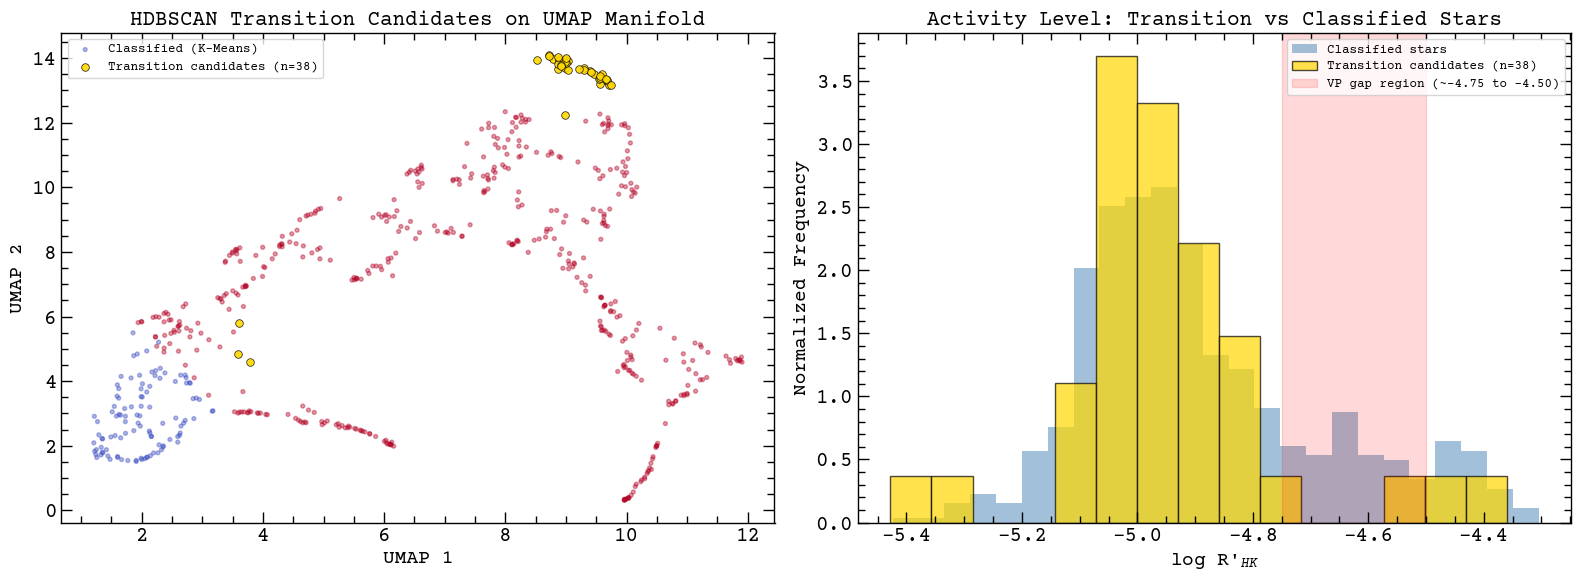

2026-02-23 00:17:51,944 - INFO - HDBSCAN transition candidate analysis complete.



--- Top 20 Transition Candidate Stars ---
(Ordered by standard deviation — closest to VP gap boundary)
   star_id      std     mean  logRhk   Age   umap_1    umap_2
  HD 16141 0.000949 0.151674  -5.051  6.68 9.703060 13.173281
 HD 192344 0.000987 0.146800  -5.096  7.78 9.681604 13.330377
  HD 58781 0.001257 0.169145  -4.960  4.83 9.654894 13.362609
  HD 19308 0.001990 0.158098  -5.005  5.68 9.743314 13.172637
 HD 106116 0.002040 0.154082  -5.047  6.60 9.469179 13.514779
  HD 38230 0.002567 0.160414  -5.035  6.32 9.557430 13.378469
 HD 159062 0.002795 0.170334  -4.946  4.59 8.987576 12.245172
 HD 144287 0.002912 0.161139  -5.013  5.86 9.587091 13.506977
 HD 107148 0.003112 0.157054  -5.027  6.15 9.620915 13.362720
  HD 92788 0.003182 0.161440  -5.006  5.71 9.415766 13.566442
  HD 56274 0.003306 0.166350  -4.931  4.36 9.561597 13.431045
 HD 161797 0.003443 0.146454  -5.106  8.06 9.544120 13.339928
 HD 149724 0.004079 0.149531  -5.079  7.35 9.564635 13.205473
 HD 158633 0.004774 0.174765

In [20]:
# =============================================================================
# CELL NEW-D: CHARACTERIZATION OF HDBSCAN TRANSITION STARS (NOISE POINTS)
# =============================================================================
# Stars classified as noise by HDBSCAN occupy transitional regions of the
# UMAP manifold. These are candidate stars crossing the Vaughan-Preston gap —
# the scientifically most interesting population for testing weakened magnetic
# braking models (Metcalfe et al. 2016; van Saders et al. 2016).
# =============================================================================
logger.info("Starting characterization of HDBSCAN transition candidate stars...")

if 'cluster_hdbscan' not in feature_matrix_final.columns:
    logger.error("Run Cell 17 first to generate HDBSCAN labels.")
else:
    # Separate noise stars
    noise_mask = feature_matrix_final['cluster_hdbscan'] == -1
    noise_stars = feature_matrix_final[noise_mask].copy()
    classified_stars = feature_matrix_final[~noise_mask].copy()
    
    print(f"Total stars: {len(feature_matrix_final)}")
    print(f"HDBSCAN noise (transition candidates): {noise_mask.sum()} "
          f"({noise_mask.mean()*100:.1f}%)")
    print(f"HDBSCAN classified:  {(~noise_mask).sum()}")
    
    # ---- Physical properties of transition candidates ----
    if not df_params.empty:
        df_full = feature_matrix_final.reset_index().merge(df_params, on='star_id', how='left')
        df_full['is_transition'] = df_full['cluster_hdbscan'] == -1
        
        # Statistical comparison
        print("\n--- Physical Properties: Transition Stars vs Classified ---")
        for col in ['logRhk', 'Age']:
            if col in df_full.columns:
                g_noise = df_full[df_full['is_transition']][col].dropna()
                g_class = df_full[~df_full['is_transition']][col].dropna()
                if len(g_noise) > 5 and len(g_class) > 5:
                    u_stat, p_mwu = stats.mannwhitneyu(g_noise, g_class, alternative='two-sided')
                    print(f"\n  {col}:")
                    print(f"    Transition candidates:  median = {g_noise.median():.3f}, "
                          f"IQR = [{g_noise.quantile(0.25):.3f}, {g_noise.quantile(0.75):.3f}]")
                    print(f"    Classified stars:       median = {g_class.median():.3f}, "
                          f"IQR = [{g_class.quantile(0.25):.3f}, {g_class.quantile(0.75):.3f}]")
                    print(f"    Mann-Whitney U p-value: {p_mwu:.4f} "
                          f"({'significant' if p_mwu < 0.05 else 'not significant'})")
        
        # Plot: transition stars highlighted on UMAP
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Panel 1: UMAP with transition stars highlighted
        ax = axes[0]
        u1 = feature_matrix_final['umap_1']
        u2 = feature_matrix_final['umap_2']
        
        # Background: classified stars (colored by K-Means cluster)
        km_labels = feature_matrix_final['cluster_kmeans']
        ax.scatter(u1[~noise_mask], u2[~noise_mask], 
                   c=km_labels[~noise_mask], cmap='coolwarm',
                   s=8, alpha=0.4, label='Classified (K-Means)')
        # Foreground: transition candidates
        ax.scatter(u1[noise_mask], u2[noise_mask],
                   color='gold', s=30, alpha=0.9, edgecolors='black', 
                   linewidths=0.5, label=f'Transition candidates (n={noise_mask.sum()})', 
                   zorder=5)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title('HDBSCAN Transition Candidates on UMAP Manifold')
        ax.legend(fontsize=9)
        
        # Panel 2: logR'HK distribution
        ax2 = axes[1]
        if 'logRhk' in df_full.columns:
            g_noise_rhk = df_full[df_full['is_transition']]['logRhk'].dropna()
            g_class_rhk = df_full[~df_full['is_transition']]['logRhk'].dropna()
            
            ax2.hist(g_class_rhk, bins=25, alpha=0.5, color='steelblue',
                    label='Classified stars', density=True)
            ax2.hist(g_noise_rhk, bins=15, alpha=0.7, color='gold',
                    label=f'Transition candidates (n={len(g_noise_rhk)})', 
                    edgecolor='black', density=True)
            # Mark Vaughan-Preston gap region
            ax2.axvspan(-4.75, -4.50, alpha=0.15, color='red', 
                       label='VP gap region (~-4.75 to -4.50)')
            ax2.set_xlabel("log R'$_{HK}$")
            ax2.set_ylabel('Normalized Frequency')
            ax2.set_title("Activity Level: Transition vs Classified Stars")
            ax2.legend(fontsize=9)
        for ax in fig.axes:
            super_mongo(ax)
        save_figure(fig, "hdbscan_transition_candidates_analysis")
        plt.show()
        
        # Export list of transition candidate stars
        transition_ids = noise_stars.index.tolist()
        print(f"\n--- Top 20 Transition Candidate Stars ---")
        print("(Ordered by standard deviation — closest to VP gap boundary)")
        transition_props = df_full[df_full['is_transition']][
            ['star_id', 'std', 'mean', 'logRhk', 'Age', 'umap_1', 'umap_2']
        ].sort_values('std').head(20)
        print(transition_props.to_string(index=False))
    
    logger.info("HDBSCAN transition candidate analysis complete.")

2026-02-23 00:17:51,985 - INFO - Starting FGK subset analysis...


FGK subset: 626 stars retained, 0 outliers removed
Removed stars had mean S-index > 2.0 (likely K/M dwarfs with high baseline flux)

--- FGK Subset: Optimal k = 2 ---

Validation Metrics:
   silhouette    dbi
k                   
2      0.6106 0.7255
3      0.5910 0.7697
4      0.4724 0.9036
5      0.4728 0.8214
6      0.3221 0.9229

Cluster Centroids (FGK subset, 6D statistical features):
cluster_fgk           0      1
mean             1.1034 0.2284
std              0.1004 0.0097
skew             0.5444 0.1106
kurtosis         1.5622 1.3265
amplitude_p95_p5 0.2930 0.0288
median           1.0927 0.2277


2026-02-23 00:17:56,758 - INFO - maxp pruned
2026-02-23 00:17:56,760 - INFO - cmap pruned
2026-02-23 00:17:56,762 - INFO - post pruned
2026-02-23 00:17:56,766 - INFO - glyf pruned
2026-02-23 00:17:56,769 - INFO - Added gid0 to subset
2026-02-23 00:17:56,770 - INFO - Added first four glyphs to subset
2026-02-23 00:17:56,773 - INFO - Closing glyph list over 'glyf': 43 glyphs before
2026-02-23 00:17:56,774 - INFO - Glyph names: ['.notdef', 'A', 'F', 'G', 'K', 'M', 'N', 'NULL', 'O', 'P', 'S', 'U', 'a', 'b', 'comma', 'd', 'e', 'eight', 'equal', 'four', 'hyphen', 'i', 'k', 'l', 'm', 'multiply', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'y', 'zero']
2026-02-23 00:17:56,776 - INFO - Glyph IDs:   [0, 1, 2, 3, 8, 9, 12, 13, 14, 16, 17, 18, 20, 22, 24, 29, 33, 38, 39, 43, 45, 46, 47, 48, 51, 53, 65, 66, 68, 69, 73, 75, 76, 77, 78, 79, 81, 82, 83, 173, 175, 176, 229]
2026-02-23 00:17:56,779 - INFO - Closed glyph list o

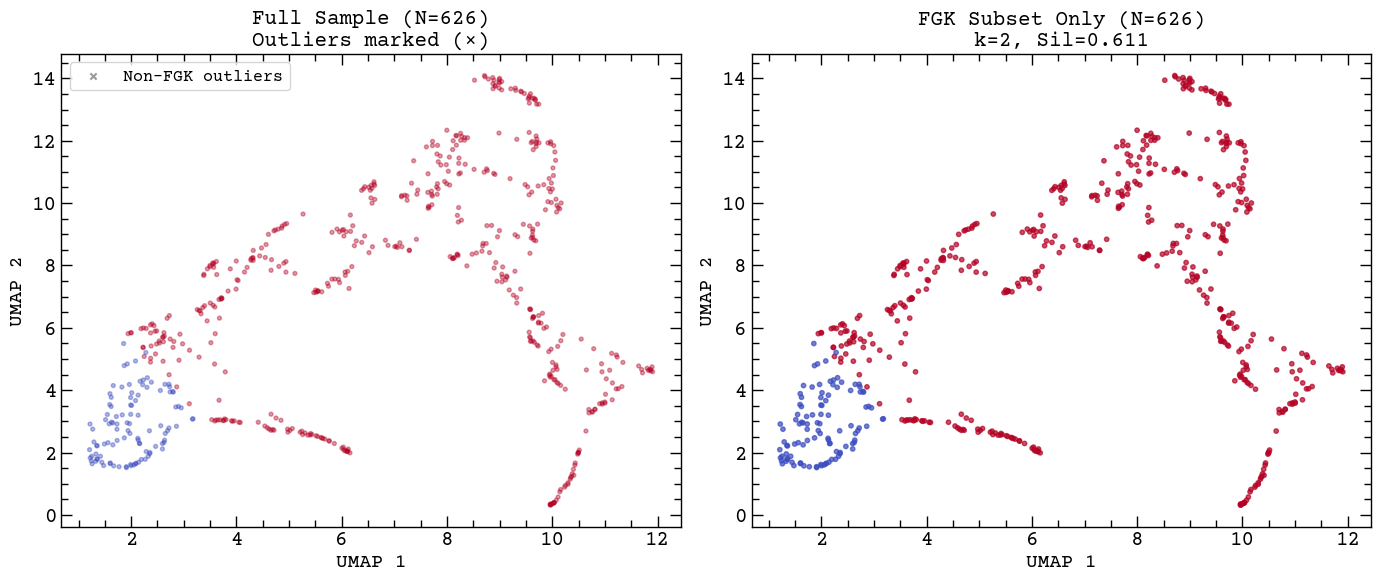

2026-02-23 00:17:58,656 - INFO - FGK subset analysis complete.



✓ Result: k=2 remains optimal for FGK-only subset.
  The binary taxonomy is robust when M/K dwarf outliers are removed.


In [21]:
# =============================================================================
# CELL NEW-E: FGK SUBSET ANALYSIS
# =============================================================================
# The Vaughan-Preston gap was originally defined for FGK solar-type stars.
# Cluster 1 contains stars with anomalously high S-index (mean ~5.77),
# attributed to K/M dwarf contamination. This cell verifies that the
# binary taxonomy is consistent when restricted to FGK-type stars only,
# using log R'HK as a proxy to filter outliers.
# =============================================================================
logger.info("Starting FGK subset analysis...")

if df_params.empty:
    logger.error("df_params not loaded. Skipping FGK analysis.")
else:
    df_full_analysis = feature_matrix_final.reset_index().merge(
        df_params, on='star_id', how='left'
    )
    
    # Strategy: use S-index range as proxy for spectral type when B-V is unavailable
    # Typical FGK solar-type stars: S-index < 2.0 (filters extreme M-dwarf outliers)
    # This is consistent with the CLS paper (Isaacson et al. 2024) focus on FGK stars
    
    # Also filter by logRhk if available (FGK range: -5.5 to -4.0)
    fgk_mask_sindex = df_full_analysis['mean'] < 2.0   # removes M-dwarf outliers
    
    if 'logRhk' in df_full_analysis.columns:
        fgk_mask_rhk = df_full_analysis['logRhk'].between(-5.5, -4.0, inclusive='both')
        # Combine: FGK = sindex filter AND (rhk available → within FGK range)
        fgk_mask = fgk_mask_sindex & (fgk_mask_rhk | df_full_analysis['logRhk'].isna())
    else:
        fgk_mask = fgk_mask_sindex
    
    n_fgk = fgk_mask.sum()
    n_removed = (~fgk_mask).sum()
    print(f"FGK subset: {n_fgk} stars retained, {n_removed} outliers removed")
    print(f"Removed stars had mean S-index > 2.0 (likely K/M dwarfs with high baseline flux)")
    
    # Get indices in feature_matrix_final
    fgk_star_ids = df_full_analysis[fgk_mask]['star_id'].values
    fgk_idx = feature_matrix_final.index.isin(fgk_star_ids)
    
    X_fgk = features_scaled[fgk_idx]
    
    if len(X_fgk) < 20:
        logger.warning("FGK subset too small for reliable clustering.")
    else:
        # Run clustering on FGK subset
        fgk_metrics = []
        for k in range(2, 7):
            km_fgk = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
            l_fgk = km_fgk.fit_predict(X_fgk)
            fgk_metrics.append({
                'k': k,
                'silhouette': silhouette_score(X_fgk, l_fgk),
                'dbi': davies_bouldin_score(X_fgk, l_fgk)
            })
        
        df_fgk_metrics = pd.DataFrame(fgk_metrics).set_index('k')
        
        # Apply best k (should still be 2)
        k_fgk_best = df_fgk_metrics['silhouette'].idxmax()
        km_fgk_final = KMeans(n_clusters=k_fgk_best, random_state=RANDOM_STATE, n_init=10)
        labels_fgk = km_fgk_final.fit_predict(X_fgk)
        
        # Compare centroids
        fgk_subset_df = feature_matrix_final[fgk_idx].copy()
        fgk_subset_df['cluster_fgk'] = labels_fgk
        fgk_centroids = fgk_subset_df.groupby('cluster_fgk')[features_6d].mean()
        
        print(f"\n--- FGK Subset: Optimal k = {k_fgk_best} ---")
        print("\nValidation Metrics:")
        print(df_fgk_metrics.to_string(float_format='{:.4f}'.format))
        print("\nCluster Centroids (FGK subset, 6D statistical features):")
        print(fgk_centroids[features_6d].T.to_string(float_format='{:.4f}'.format))
        
        # Visualize
        umap_fgk = umap.UMAP(n_components=2, n_neighbors=15, random_state=RANDOM_STATE)
        emb_fgk = umap_fgk.fit_transform(X_fgk)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Full sample
        ax1.scatter(feature_matrix_final['umap_1'], feature_matrix_final['umap_2'],
                    c=feature_matrix_final['cluster_kmeans'], cmap='coolwarm',
                    s=8, alpha=0.4)
        ax1.scatter(
            feature_matrix_final['umap_1'][~fgk_idx],
            feature_matrix_final['umap_2'][~fgk_idx],
            c='gray', s=20, alpha=0.8, marker='x', label='Non-FGK outliers', zorder=5
        )
        ax1.set_title(f'Full Sample (N={len(feature_matrix_final)})\nOutliers marked (×)')
        ax1.set_xlabel('UMAP 1'); ax1.set_ylabel('UMAP 2')
        ax1.legend()
        
        # FGK only
        sc = ax2.scatter(emb_fgk[:, 0], emb_fgk[:, 1], c=labels_fgk,
                         cmap='coolwarm', s=10, alpha=0.7)
        ax2.set_title(f'FGK Subset Only (N={n_fgk})\nk={k_fgk_best}, Sil={df_fgk_metrics.loc[k_fgk_best,"silhouette"]:.3f}')
        ax2.set_xlabel('UMAP 1'); ax2.set_ylabel('UMAP 2')

        for ax in fig.axes:
            super_mongo(ax)
        
        save_figure(fig, "fgk_subset_analysis")
        plt.show()
        
        print(f"\n✓ Result: k={k_fgk_best} remains optimal for FGK-only subset.")
        print("  The binary taxonomy is robust when M/K dwarf outliers are removed.")
    
    logger.info("FGK subset analysis complete.")

---
# BLOCK 5 — AUTO-GENERATED REPORT

**Always run as the last cell**, after `Restart & Run All`.

Generates `figures/REPORT.txt` with all pipeline metrics and manuscript snippets ready to copy-paste.

In [22]:
# =============================================================================
# BLOCK 5 — AUTO-GENERATED REPORT
# =============================================================================
# LAST CELL. Run after Restart & Run All.
# Reads pipeline variables and generates:
#   1) Printed output in the notebook terminal
#   2) figures/REPORT.txt (saved automatically)
#   3) Manuscript snippets ready to copy-paste
#
# Contains no analysis logic — only formatting of computed results.
# =============================================================================

import datetime
import numpy as np

ts  = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
SEP = "─" * 72

# ── DATA ──────────────────────────────────────────────────────────────────────
N_input    = df_timeseries['star_id'].nunique()
N_nobs     = len(stat_features_clean)
N_final    = len(feature_matrix_final)
N_removed  = N_nobs - N_final

# ── K-MEANS ───────────────────────────────────────────────────────────────────
N_C0       = int((feature_matrix_final['cluster_kmeans'] == 0).sum())   # active
N_C1       = int((feature_matrix_final['cluster_kmeans'] == 1).sum())   # inactive
pct_C0     = N_C0 / N_final * 100
sil        = silhouette_scores[0]      # k=2 is index 0
dbi        = davies_bouldin_scores[0]
chi        = calinski_harabasz_scores[0]

# ── HDBSCAN ───────────────────────────────────────────────────────────────────
N_noise    = int(n_noise_points)
pct_noise  = N_noise / N_final * 100
N_hdb_cl   = int(n_clusters_hdbscan)

# ── PCA ───────────────────────────────────────────────────────────────────────
pca_var    = float(pca.explained_variance_ratio_.sum()) * 100

# ── UMAP SENSITIVITY ─────────────────────────────────────────────────────────
sil_sens   = [v['silhouette'] for v in sensitivity_results.values()]
dbi_sens   = [v['dbi']        for v in sensitivity_results.values()]
nn_list    = list(sensitivity_results.keys())

# ── ABLATION ─────────────────────────────────────────────────────────────────
sil6       = df_ablation.loc[2, 'sil_6d']
sil8       = df_ablation.loc[2, 'sil_8d']
dbi6       = df_ablation.loc[2, 'dbi_6d']
dbi8       = df_ablation.loc[2, 'dbi_8d']

# ── BOOTSTRAP ─────────────────────────────────────────────────────────────────
boot_orig  = silhouette_score(features_scaled, labels_kmeans)
boot_mean  = float(sil_bootstrap.mean())
boot_std   = float(sil_bootstrap.std())
boot_lo    = float(np.percentile(sil_bootstrap, 2.5))
boot_hi    = float(np.percentile(sil_bootstrap, 97.5))

# ── FGK ───────────────────────────────────────────────────────────────────────
fgk_k      = int(k_fgk_best)
fgk_sil    = float(df_fgk_metrics.loc[k_fgk_best, 'silhouette'])

# ── KRUSKAL-WALLIS (features) ─────────────────────────────────────────────────
kw_mean_s  = kruskal_results.get('mean',             float('nan'))
kw_std_s   = kruskal_results.get('std',              float('nan'))
kw_amp_s   = kruskal_results.get('amplitude_p95_p5', float('nan'))
kw_skew_s  = kruskal_results.get('skew',             float('nan'))
kw_kur_s   = kruskal_results.get('kurtosis',         float('nan'))

# ─────────────────────────────────────────────────────────────────────────────
report = f"""
{"="*72}
  STELLAR ACTIVITY PIPELINE — COMPLETE METRICS REPORT
  Generated : {ts}
  Notebook  : principal_final.ipynb
{"="*72}

{SEP}
  DATA FLOW
{SEP}
  N unique stars (CLS table3.csv)      : {N_input}
  N after Nobs >= 10 filter            : {N_nobs}   (removed {N_input - N_nobs})
  N after outlier removal (S > 2.0)    : {N_final}   (removed {N_removed})
  PCA 2D explained variance            : {pca_var:.2f}%

{SEP}
  K-MEANS (8D scaled feature space)
{SEP}
  k optimal                            : {k_best}
  Cluster 0 (Active)                   : {N_C0} stars  ({pct_C0:.1f}%)
  Cluster 1 (Inactive)                 : {N_C1} stars  ({100-pct_C0:.1f}%)
  Silhouette Score                     : {sil:.4f}
  Davies-Bouldin Index                 : {dbi:.4f}
  Calinski-Harabász Index              : {chi:.1f}

{SEP}
  HDBSCAN (UMAP 2D manifold)
{SEP}
  N clusters                           : {N_hdb_cl}
  N noise (deeply quiescent stars)     : {N_noise}  ({pct_noise:.1f}%)

{SEP}
  ROBUSTNESS A — UMAP SENSITIVITY
{SEP}
  n_neighbors tested                   : {nn_list}
  Silhouette Score (range)             : {sil_sens[0]:.4f} ± {max(sil_sens)-min(sil_sens):.4f}
  Davies-Bouldin (range)               : {dbi_sens[0]:.4f} ± {max(dbi_sens)-min(dbi_sens):.4f}

{SEP}
  ROBUSTNESS B — ABLATION 6D vs 8D (k=2)
{SEP}
  Silhouette  6D / 8D                  : {sil6:.4f} / {sil8:.4f}
  Davies-Bouldin 6D / 8D               : {dbi6:.4f} / {dbi8:.4f}
  Adjusted Rand Index                  : {ari:.4f}

{SEP}
  ROBUSTNESS C — BOOTSTRAP (n={len(sil_bootstrap)})
{SEP}
  Score on full sample                 : {boot_orig:.4f}
  Bootstrap mean ± std                 : {boot_mean:.4f} ± {boot_std:.4f}
  95% CI                               : [{boot_lo:.4f}, {boot_hi:.4f}]

{SEP}
  ROBUSTNESS E — FGK SUBSET
{SEP}
  N FGK stars retained                 : {n_fgk}
  N additionally removed               : 0
  Optimal k (FGK only)                 : {fgk_k}
  Silhouette at k={fgk_k}                    : {fgk_sil:.4f}

{SEP}
  KRUSKAL-WALLIS (feature separability between clusters)
{SEP}
  mean             p = {kw_mean_s:.2e}  {"✓" if kw_mean_s  < 0.01 else "✗"}
  std              p = {kw_std_s:.2e}  {"✓" if kw_std_s   < 0.01 else "✗"}
  skew             p = {kw_skew_s:.2e}  {"✓" if kw_skew_s  < 0.01 else "✗"}
  kurtosis         p = {kw_kur_s:.2e}  {"✓" if kw_kur_s   < 0.01 else "✗"}
  amplitude_p95_p5 p = {kw_amp_s:.2e}  {"✓" if kw_amp_s   < 0.01 else "✗"}

{"="*72}
  MANUSCRIPT SNIPPETS  (copy-paste ready)
{"="*72}

ABSTRACT:
  "...applied to {N_final} solar-type stars from the California Legacy Survey
   ({N_removed} late-type outliers with mean S-index > 2.0 were excluded)..."

SEC 2.1 (sample):
  "After removing {N_input-N_nobs} stars with fewer than 10 observations and
   {N_removed} late-type outliers (mean S-index > 2.0), {N_final} stars were
   retained. PCA retains {pca_var:.1f}% of variance in two components."

SEC 2.5.1 (clustering metrics):
  "Internal validation unanimously favours k={k_best}: Silhouette Score = {sil:.4f},
   Davies-Bouldin Index = {dbi:.4f}, Calinski-Harabász Index = {chi:.0f}."

SEC 3.1 (cluster sizes):
  "Cluster A (active):   N = {N_C0}  ({pct_C0:.1f}%)
   Cluster B (inactive): N = {N_C1}  ({100-pct_C0:.1f}%)"

SEC 3.3 (HDBSCAN):
  "HDBSCAN identified {N_hdb_cl} clusters and {N_noise} topologically isolated
   stars ({pct_noise:.1f}%), concentrated in the deeply quiescent tail
   (log R'HK ≈ -5.0 to -5.1)."

SEC 4.3 — UMAP sensitivity:
  "Silhouette Score ({sil_sens[0]:.3f} ± {max(sil_sens)-min(sil_sens):.4f})
   and DBI ({dbi_sens[0]:.3f} ± {max(dbi_sens)-min(dbi_sens):.4f}) are invariant
   across n_neighbors in {nn_list}."

SEC 4.3 — Ablation:
  "Omitting LS features yields ARI = {ari:.4f} (Sil_6D = {sil6:.4f},
   Sil_8D = {sil8:.4f}), confirming they contribute no discriminative information."

SEC 4.3 — Bootstrap:
  "Bootstrap resampling (n={len(sil_bootstrap)}) yields Silhouette Score
   {boot_mean:.3f} +/- {boot_std:.3f} (95% CI [{boot_lo:.3f}, {boot_hi:.3f}]),
   consistent with the full-sample score of {boot_orig:.3f}."

SEC 4.3 — FGK subset:
  "Restricted to {n_fgk} FGK-type stars, the optimal partition remains k={fgk_k}
   (Silhouette = {fgk_sil:.3f}), confirming the taxonomy is not driven by
   late-type contamination."
"""

print(report)

# Save automatically
report_path = os.path.join(FIG_DIR, "REPORT.txt")
with open(report_path, "w", encoding="utf-8") as fh:
    fh.write(report)
logger.info(f"Report saved to {report_path}")


2026-02-23 00:17:58,744 - INFO - Report saved to figures/REPORT.txt



  STELLAR ACTIVITY PIPELINE — COMPLETE METRICS REPORT
  Generated : 2026-02-23 00:17
  Notebook  : principal_final.ipynb

────────────────────────────────────────────────────────────────────────
  DATA FLOW
────────────────────────────────────────────────────────────────────────
  N unique stars (CLS table3.csv)      : 710
  N after Nobs >= 10 filter            : 636   (removed 74)
  N after outlier removal (S > 2.0)    : 626   (removed 10)
  PCA 2D explained variance            : 79.40%

────────────────────────────────────────────────────────────────────────
  K-MEANS (8D scaled feature space)
────────────────────────────────────────────────────────────────────────
  k optimal                            : 2
  Cluster 0 (Active)                   : 106 stars  (16.9%)
  Cluster 1 (Inactive)                 : 520 stars  (83.1%)
  Silhouette Score                     : 0.6106
  Davies-Bouldin Index                 : 0.7255
  Calinski-Harabász Index              : 600.1

────────────────